In [1]:
import os
import json
import gzip

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable

import tabulate


In [118]:
# functions
geolocator = Nominatim(user_agent="geoapiExercises")

def get_address_and_coordinates(city):
    try:
        # Preprocess the city name: trim leading/trailing whitespace
        city_clean = city.strip()
        location = geolocator.geocode(city_clean, language='en', timeout=10)
        if location:
            return location.address, (location.latitude, location.longitude)
        else:
            return f"Could not find {city}", None
    except (GeocoderTimedOut, GeocoderUnavailable) as e:
        return f"Geocoding error: {str(e)}", None

def unpack_pecan_zip(zip_path, temp_dir):
    # Unpack the zip file
    pass

def drop_100_na(df):
    # Drop rows with 100% NA
    nan_counts = df.isna().mean()
    df = df.drop(nan_counts[nan_counts == 1].index, axis=1)
    return df

def plot_houses(dataframes, channel, num_weeks):
    out = []
    for house, df in dataframes[channel].sort_values('dataid').groupby('dataid'):
        drop_cols = ['dataid', 'local_15min', 'leg1v', 'leg2v', ]
        _df = (
            df
            .pipe(drop_100_na)
            .sort_values('local_15min', ascending=True)
            .drop(columns=drop_cols, errors='ignore')
            .fillna(0)
            .iloc[:int(24*4 * 7 * num_weeks)]
            .reset_index(drop=True)
        )

        # skip conditions
        if (
            'solar' in _df.columns
            or 'energy_storage_system' in _df.columns
            or len(_df.columns) < 2
            or np.any(_df.grid < 0)
        ):
            continue

        loads = (
                _df
                .pipe(lambda x: x[[col for col in x.columns if col not in ['solar', 'grid', 'energy_storage_system']]])
            )
        
        grid = _df['grid']

        delta = grid - loads.sum(axis=1)

        
        # plot
        fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
        title = f'House {house}, {channel} for {num_weeks} weeks'
        plt.suptitle(title)
        
        loads.plot.area(ax=ax[0], alpha=0.5, stacked=False)
        ax[1].plot(grid, label='grid')
        ax[2].plot(delta, label='delta')
        
        ax[0].set_title('Loads')
        ax[1].set_title('Grid')
        ax[2].set_title('Delta')

        ax[0].legend()
        
        plt.show()

        out.append(house)
    
    return out

def plot_houses_with_solar(dataframes, channel, num_weeks):
    out = []
    for house, df in dataframes[channel].sort_values('dataid').groupby('dataid'):
        drop_cols = ['dataid', 'local_15min', 'leg1v', 'leg2v', ]
        _df = (
            df
            .pipe(drop_100_na)
            .sort_values('local_15min', ascending=True)
            .drop(columns=drop_cols, errors='ignore')
            .fillna(0)
            .iloc[:int(24*4 * 7 * num_weeks)]
            .reset_index(drop=True)
        )

        # skip conditions
        if ('solar' not in _df.columns and 'energy_storage_system' not in _df.columns):
            continue

        loads = (
            _df
            .drop(columns=['solar', 'grid', 'energy_storage_system'], errors='ignore')
        )
        
        grid = _df['grid']

        solar = _df['solar'] if 'solar' in _df.columns else np.zeros_like(grid)

        battery = _df['energy_storage_system'] if 'energy_storage_system' in _df.columns else np.zeros_like(grid)

        # plot
        fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
        title = f'House {house}, {channel} for {num_weeks} weeks'
        plt.suptitle(title)
        
        if loads.shape[1] >= 1:
            loads.plot.area(ax=ax[0], alpha=0.5, stacked=False)
            ax[1].plot(grid, label='grid')
        
        ax[2].plot(solar, label='solar')
        ax[2].plot(battery, label='battery')
        
        ax[0].set_title('Loads')
        ax[1].set_title('Grid')
        ax[2].set_title('Solar/Battery')

        ax[0].legend()
        ax[2].legend()
        
        plt.show()

        out.append(house)
    
    return out

In [92]:
metadata_path = '/Users/darwish/Documents/Berkeley_Offline/W210/capstone/data/pecan_street/15_min/pr_15min/metadata.csv'

df_metadata = pd.read_csv(metadata_path)
column_description = df_metadata.iloc[0,:].copy().rename('desciption').to_frame()
df_metadata = df_metadata.drop(index=0)

In [93]:
print(tabulate.tabulate(column_description, headers='keys', tablefmt='psql'))

+-------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [94]:
# cities = list(df_metadata['city'].str.lower().unique())
# geo_info = {city:get_address_and_coordinates(city) for city in cities}
# with open('./pecan__geo_info.json', 'w') as f:
#     json.dump(geo_info, f)

with open('./pecan__geo_info.json', 'r') as f:
    geo_info = json.load(f)

In [95]:
df_metadata = (
    df_metadata
    .assign(
        city=lambda x: x['city'].str.lower(),
        address = lambda x: x['city'].apply(lambda city: geo_info[city][0] if geo_info[city] else None),
        country=lambda x: x['city'].apply(lambda city: geo_info[city][0].split(",")[-1].strip() if geo_info[city] else None),
        coordinates=lambda x: x['city'].apply(lambda city: geo_info[city][1] if geo_info[city] else None)
    )
)

In [96]:
df_puerto_rico = (
    df_metadata.
    loc[df_metadata['state'].str.lower().str.contains('puerto')]
    .pipe(drop_100_na)
    .set_index('dataid')
)

In [97]:
df_puerto_rico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 7209 to 2895
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   active_record                  49 non-null     object
 1   building_type                  49 non-null     object
 2   city                           49 non-null     object
 3   state                          49 non-null     object
 4   egauge_1min_min_time           32 non-null     object
 5   egauge_1min_max_time           32 non-null     object
 6   egauge_1min_data_availability  32 non-null     object
 7   egauge_1s_min_time             32 non-null     object
 8   egauge_1s_max_time             32 non-null     object
 9   egauge_1s_data_availability    32 non-null     object
 10  air1                           7 non-null      object
 11  air2                           3 non-null      object
 12  air3                           1 non-null      object
 13  airwind

In [98]:
# import data
data_dir = '/Users/darwish/Documents/Berkeley_Offline/W210/capstone/data/pecan_street/15_min/pr_15min'
dataframes = {

}
for file in os.listdir(data_dir):
    if not file.endswith('.csv.gz'):
        continue
    print('processing ', file, ' ...')
    *_, channel, month_year, resolution = file.split('_')
    
    if channel not in dataframes:
        dataframes[channel] = []

    with gzip.open(os.path.join(data_dir, file), 'rt') as f:
        df = pd.read_csv(f)
    
    dataframes[channel].append(df)

processing  pr_realpower_10-2023_15min.csv.gz  ...
processing  pr_angle_11-2023_15min.csv.gz  ...
processing  pr_realpower_09-2023_15min.csv.gz  ...
processing  pr_realpower_11-2023_15min.csv.gz  ...
processing  pr_angle_10-2023_15min.csv.gz  ...
processing  pr_angle_09-2023_15min.csv.gz  ...
processing  pr_current_10-2023_15min.csv.gz  ...
processing  pr_current_09-2023_15min.csv.gz  ...
processing  pr_current_11-2023_15min.csv.gz  ...
processing  pr_apparentpower_11-2023_15min.csv.gz  ...
processing  pr_thd_10-2023_15min.csv.gz  ...
processing  pr_thd_09-2023_15min.csv.gz  ...
processing  pr_apparentpower_10-2023_15min.csv.gz  ...
processing  pr_thd_11-2023_15min.csv.gz  ...
processing  pr_apparentpower_09-2023_15min.csv.gz  ...


In [99]:
# find common columns across all dataframes
common_columns = None

for channel, dfs in dataframes.items():
    if common_columns is None:
        common_columns = set(dfs[0].columns)
    else:
        common_columns = common_columns.intersection(set(dfs[0].columns))

    for df in dfs[1:]:
        common_columns = common_columns.intersection(set(df.columns))

print(len(common_columns))


for channel, dfs in dataframes.items():
    print(channel)
    for df in dfs:
        print('\t', df.shape)    
        unique_columns = set(df.columns).difference(common_columns)
        print('\t', unique_columns)
        print()

    print()


79
realpower
	 (72755, 82)
	 {'leg1v', 'leg2v', 'grid'}

	 (59137, 82)
	 {'leg1v', 'leg2v', 'grid'}

	 (66778, 82)
	 {'leg1v', 'leg2v', 'grid'}


angle
	 (66778, 81)
	 {'grid_l1', 'grid_l2'}

	 (72755, 81)
	 {'grid_l1', 'grid_l2'}

	 (59137, 81)
	 {'grid_l1', 'grid_l2'}


current
	 (72755, 81)
	 {'grid_l1', 'grid_l2'}

	 (59137, 81)
	 {'grid_l1', 'grid_l2'}

	 (66778, 81)
	 {'grid_l1', 'grid_l2'}


apparentpower
	 (66778, 80)
	 {'grid'}

	 (72755, 80)
	 {'grid'}

	 (59137, 80)
	 {'grid'}


thd
	 (72755, 81)
	 {'grid_l1', 'grid_l2'}

	 (59137, 81)
	 {'grid_l1', 'grid_l2'}

	 (66778, 81)
	 {'grid_l1', 'grid_l2'}




In [100]:
_dataframes = {}
for k, v in dataframes.items():
    _dataframes[k] = pd.concat(v, axis=0).pipe(drop_100_na)
dataframes = _dataframes

In [102]:
for i, (grp, df) in enumerate(dataframes['apparentpower'].groupby('dataid')):
    _df = df.pipe(drop_100_na)
    print(i, grp, f'{len(_df) / 4 / 24:0.1f} days', f'{len(_df.columns)} features', sep='\t')
    

0	371	90.3 days	7 features
1	939	90.5 days	7 features
2	1092	90.6 days	3 features
3	1245	91.1 days	7 features
4	1286	77.3 days	4 features
5	2006	91.1 days	4 features
6	2159	79.3 days	8 features
7	2921	55.5 days	3 features
8	3835	91.1 days	3 features
9	3987	34.5 days	11 features
10	4046	91.1 days	3 features
11	4204	91.1 days	9 features
12	4749	79.3 days	3 features
13	6056	79.3 days	5 features
14	6406	79.3 days	7 features
15	7667	80.3 days	12 features
16	7778	91.1 days	3 features
17	8235	78.6 days	6 features
18	8997	79.3 days	5 features
19	9911	90.3 days	3 features
20	10826	87.5 days	8 features
21	10887	89.8 days	3 features
22	11126	91.1 days	8 features
23	11386	91.1 days	9 features
24	11933	79.3 days	5 features


In [105]:
px.imshow(
    df_puerto_rico.loc[house_ids, :].isna().astype('int').T,
    height=800,
    width=1200,
    color_continuous_scale=[(0, 'black'), (1, 'white')],
).update_layout(coloraxis_showscale=False)

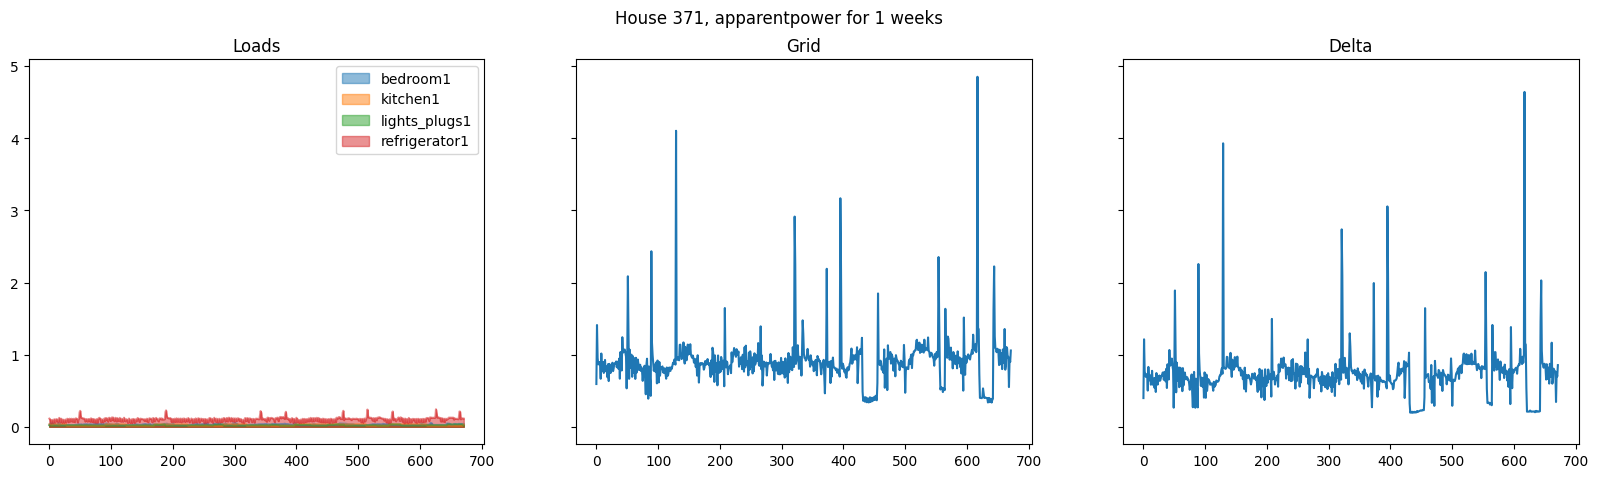

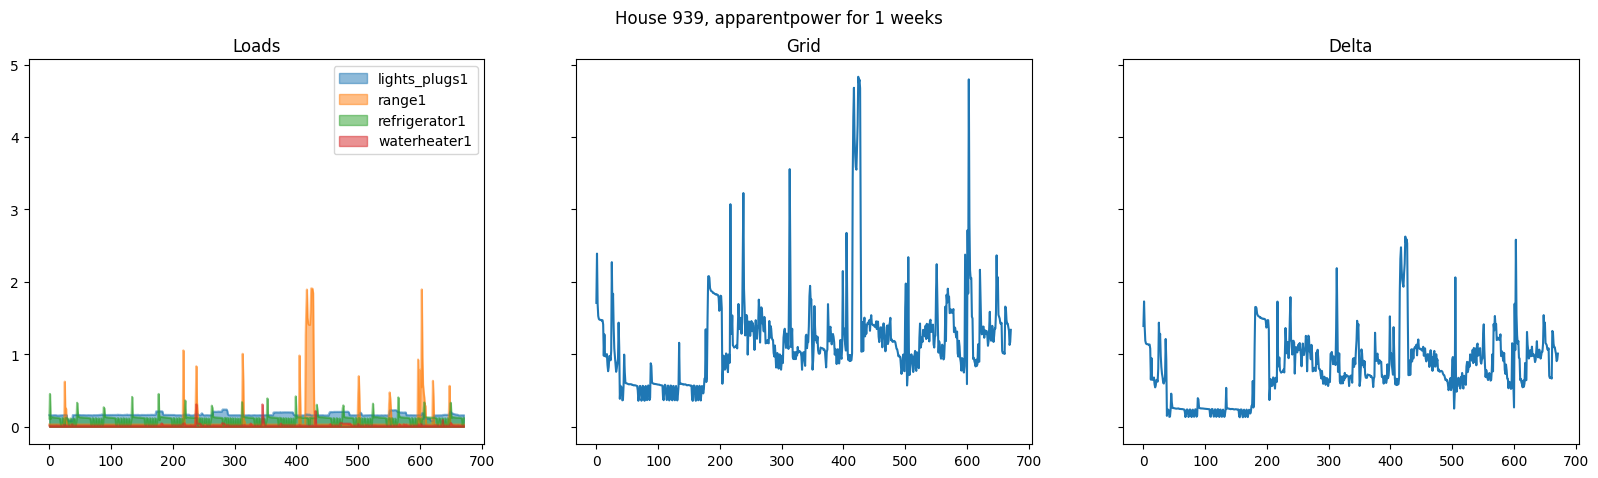

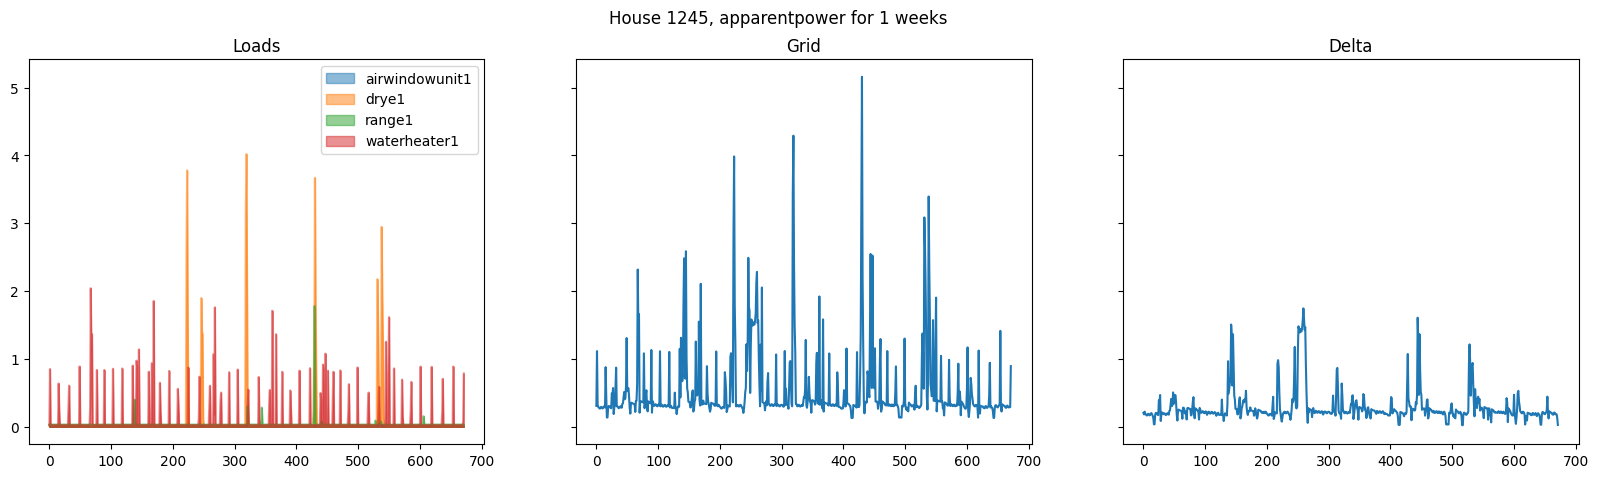

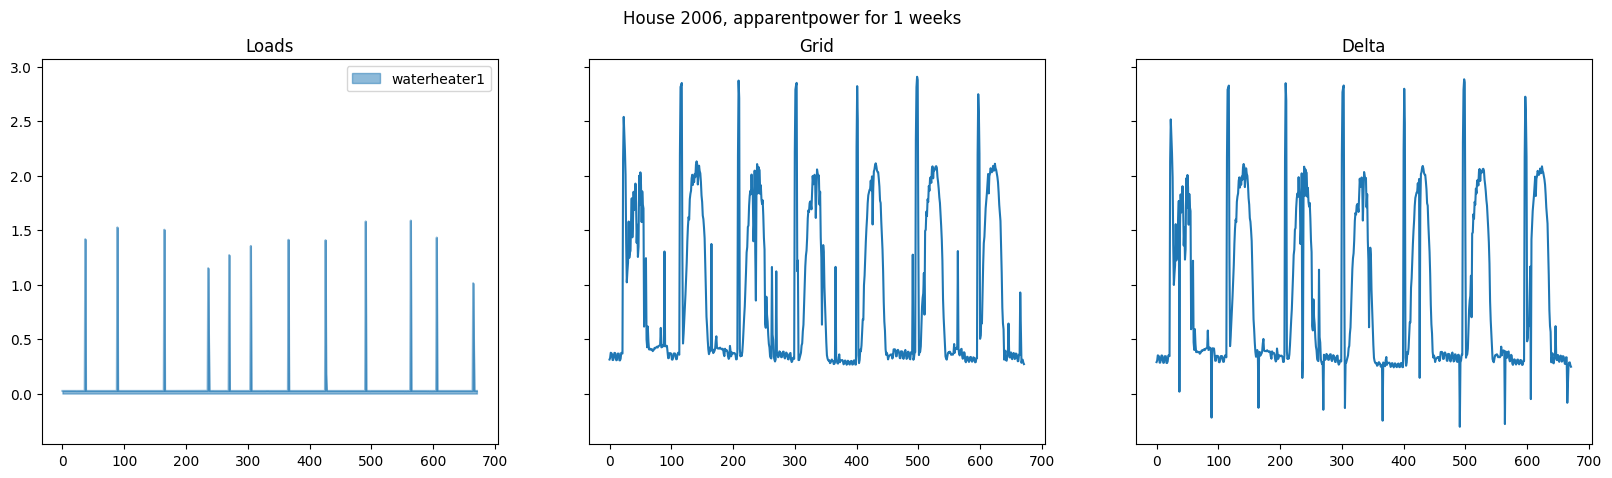

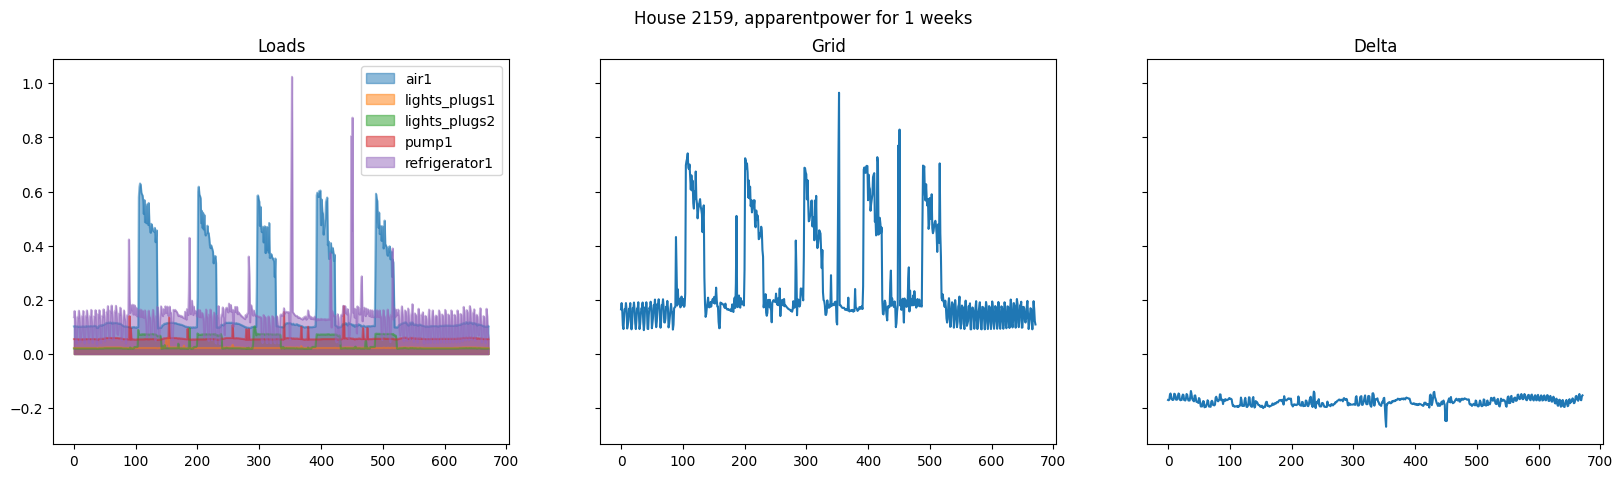

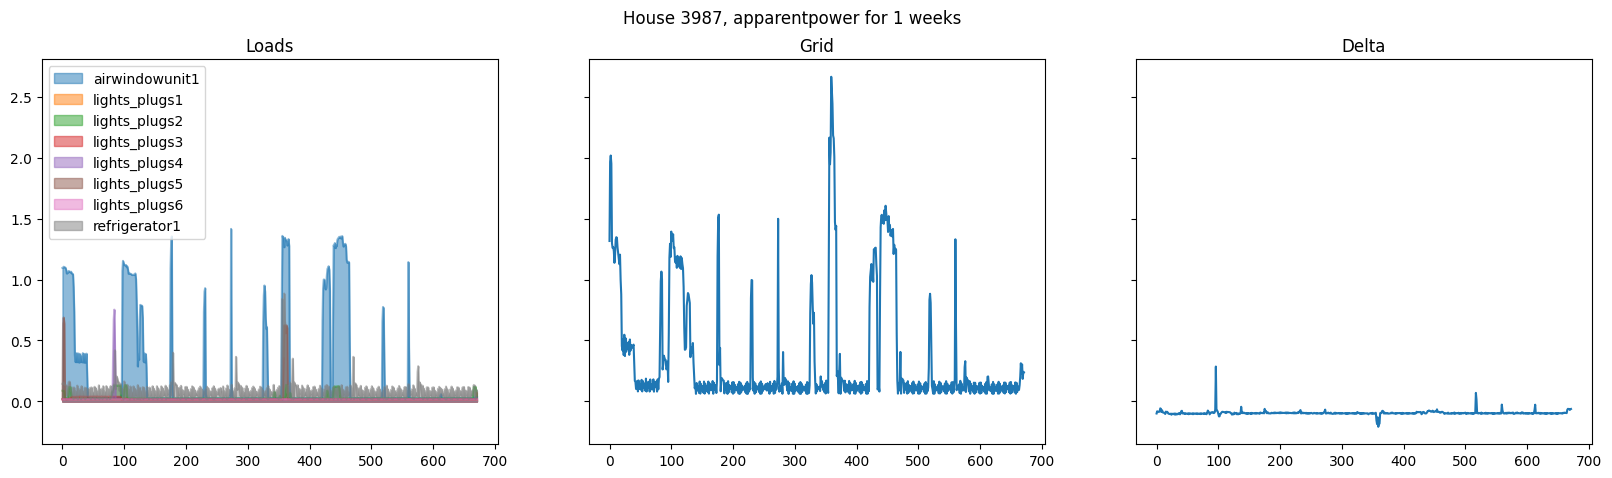

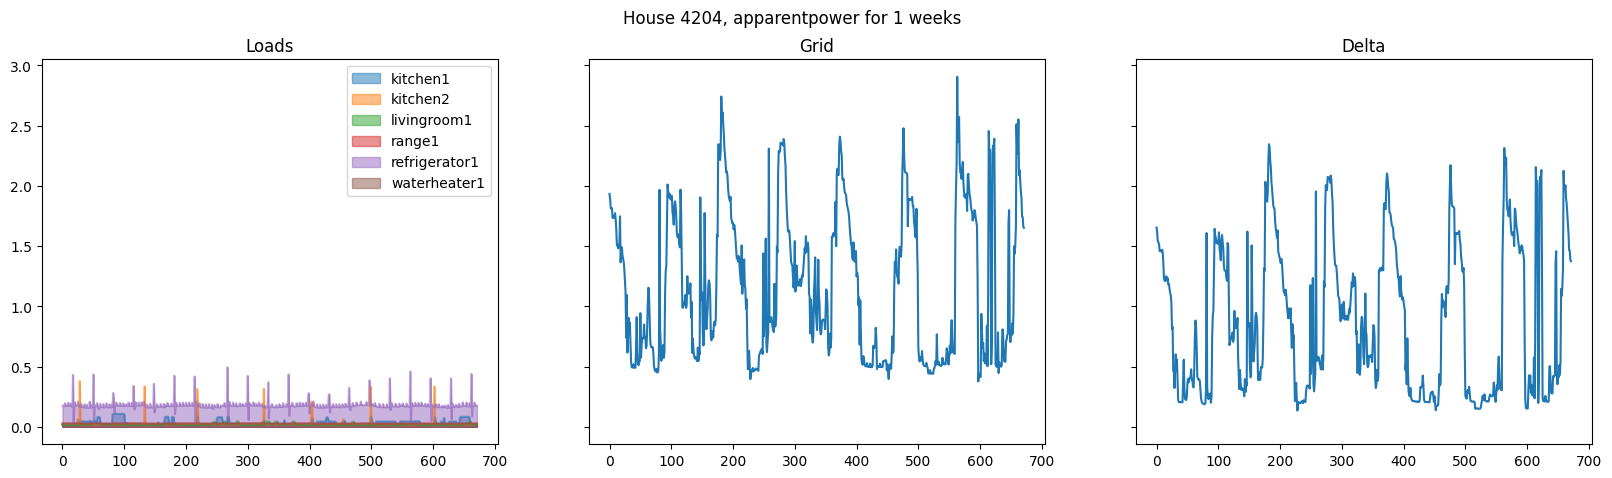

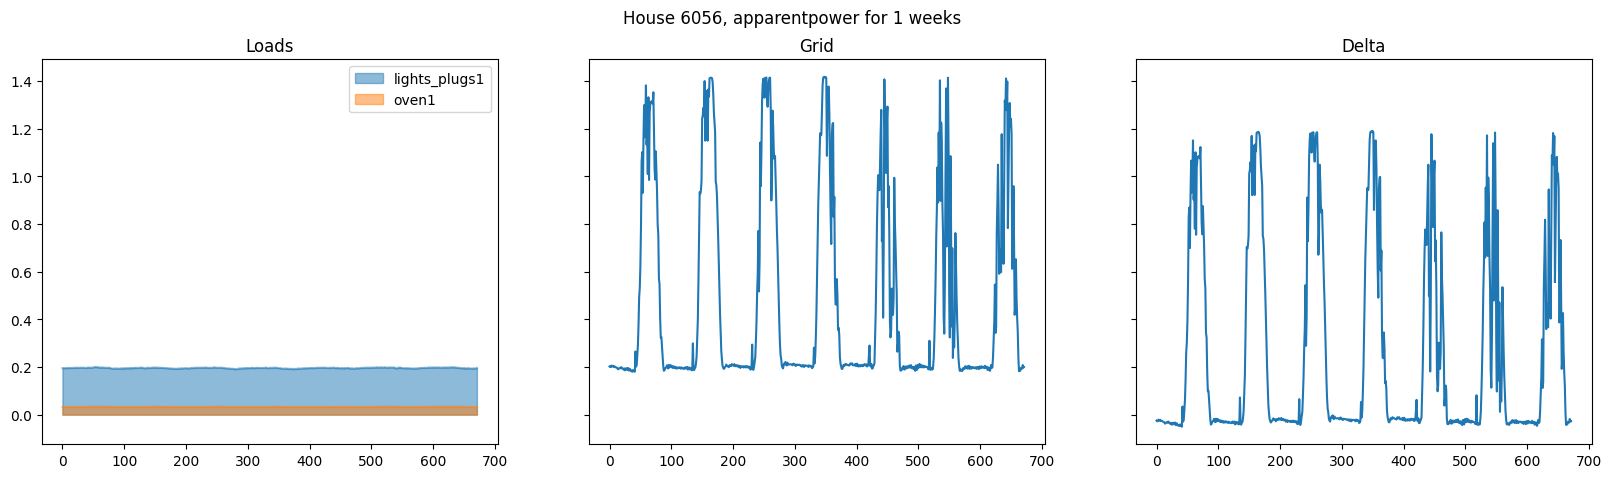

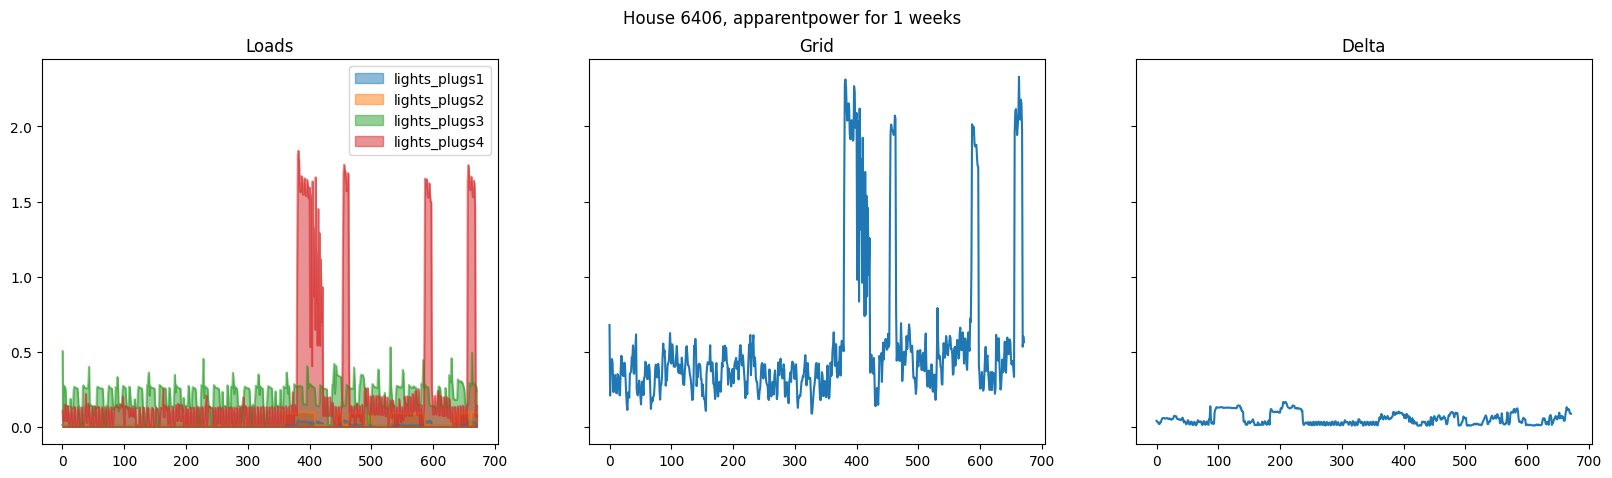

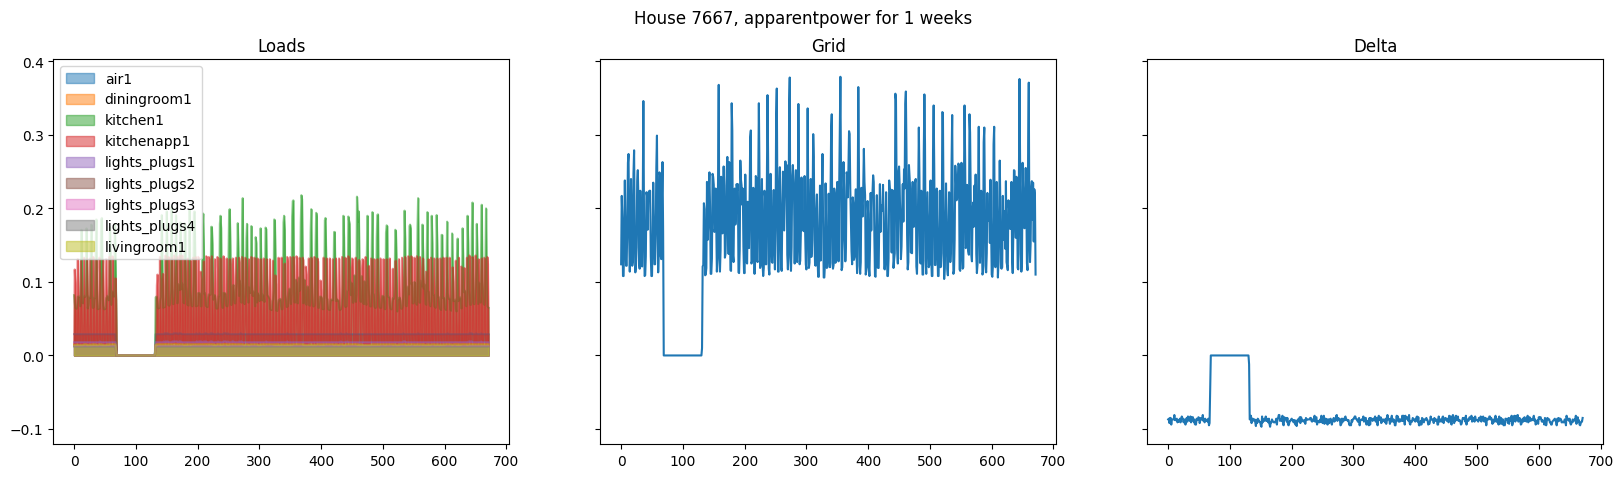

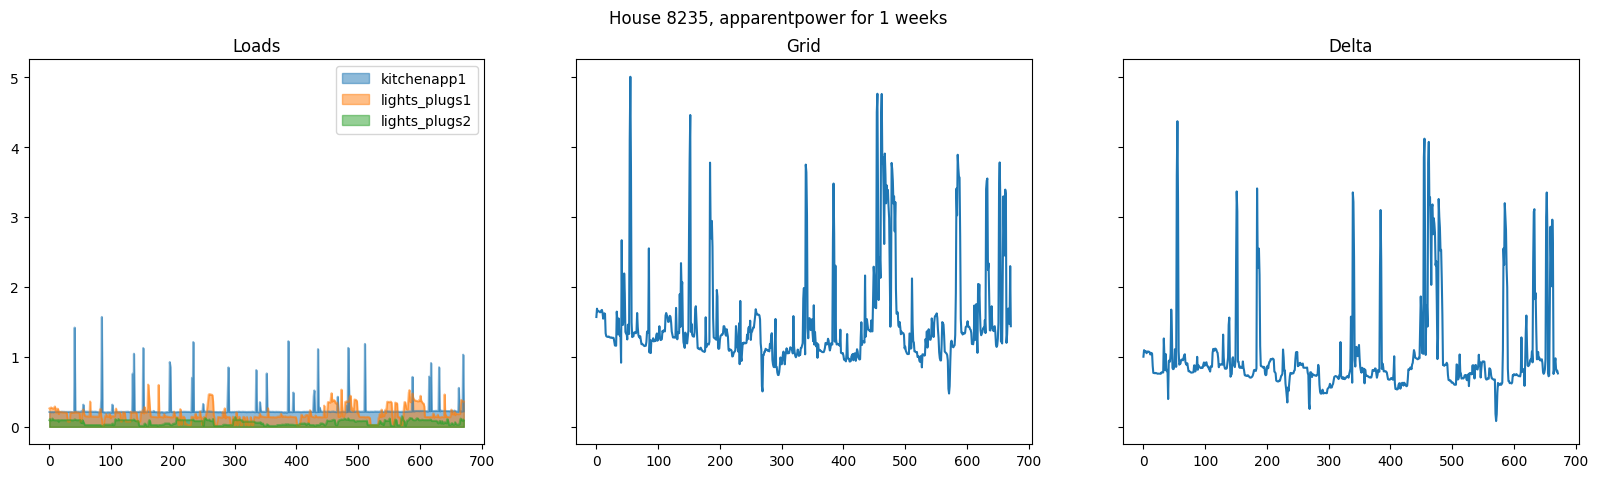

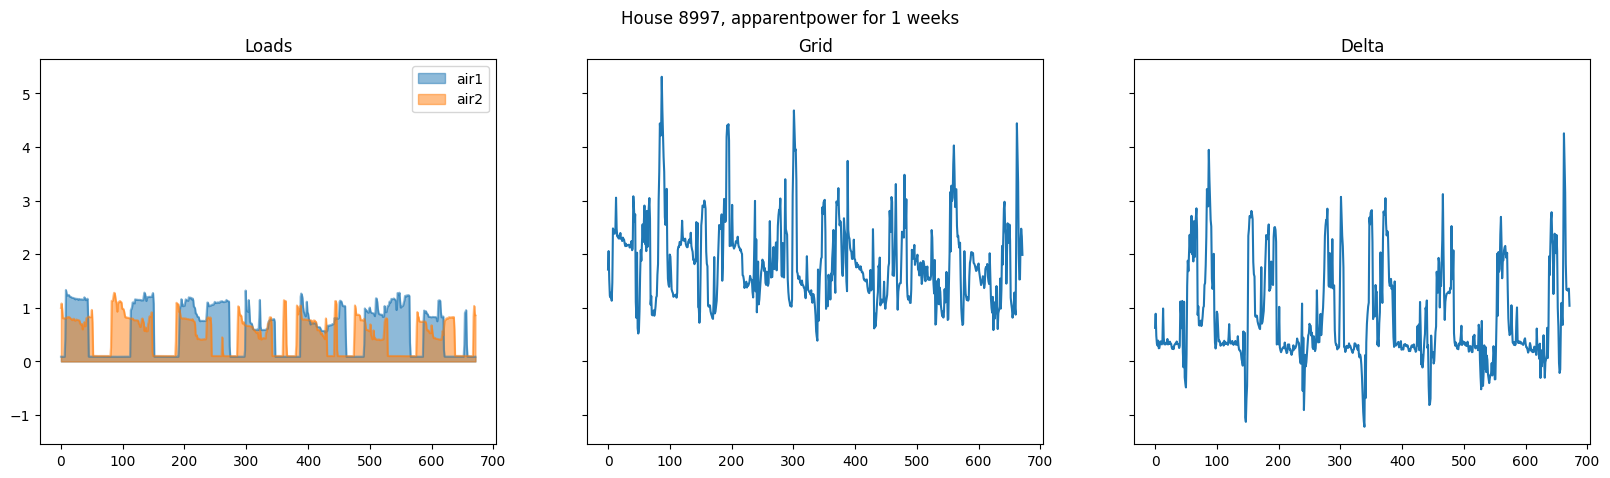

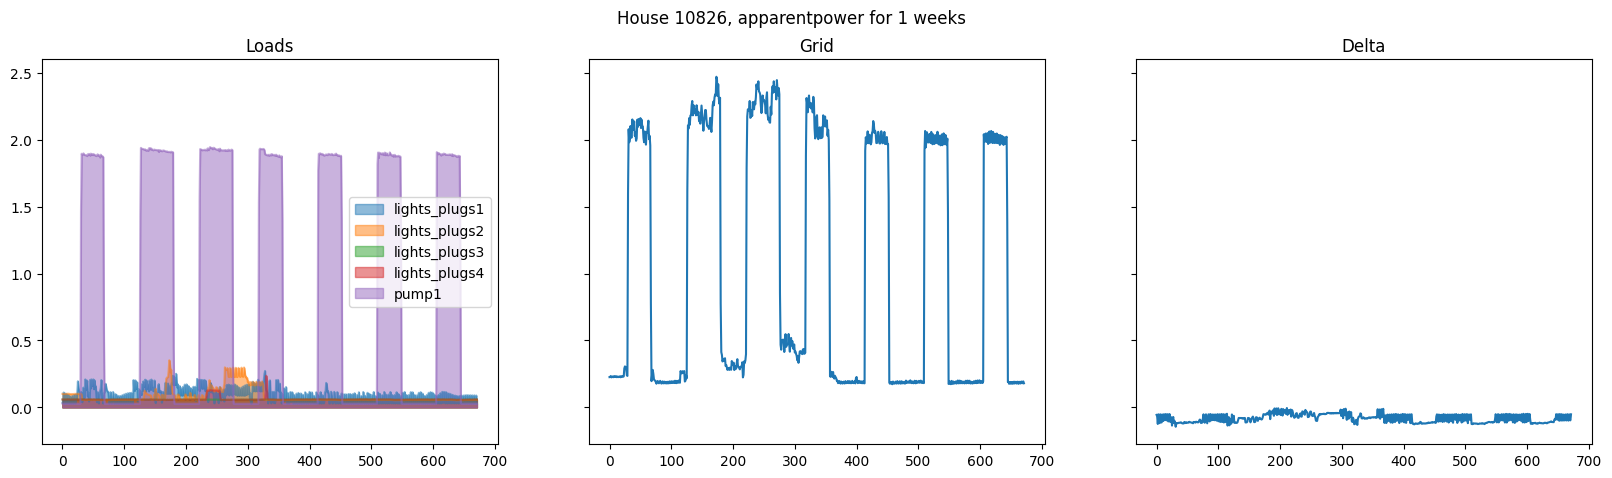

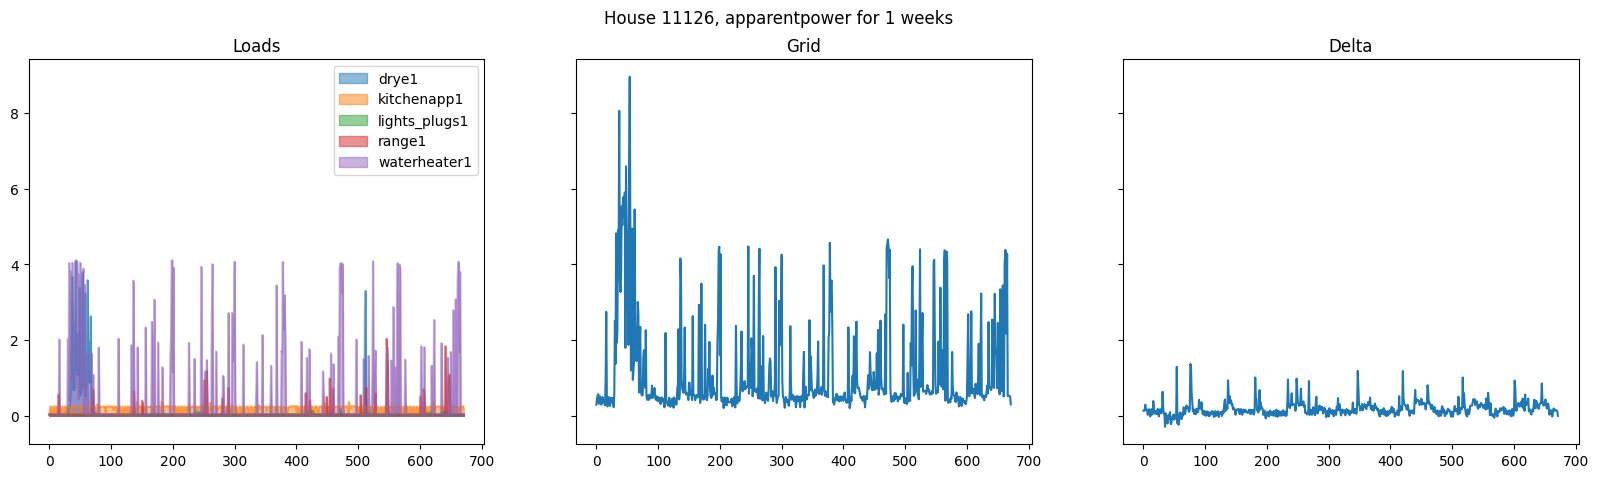

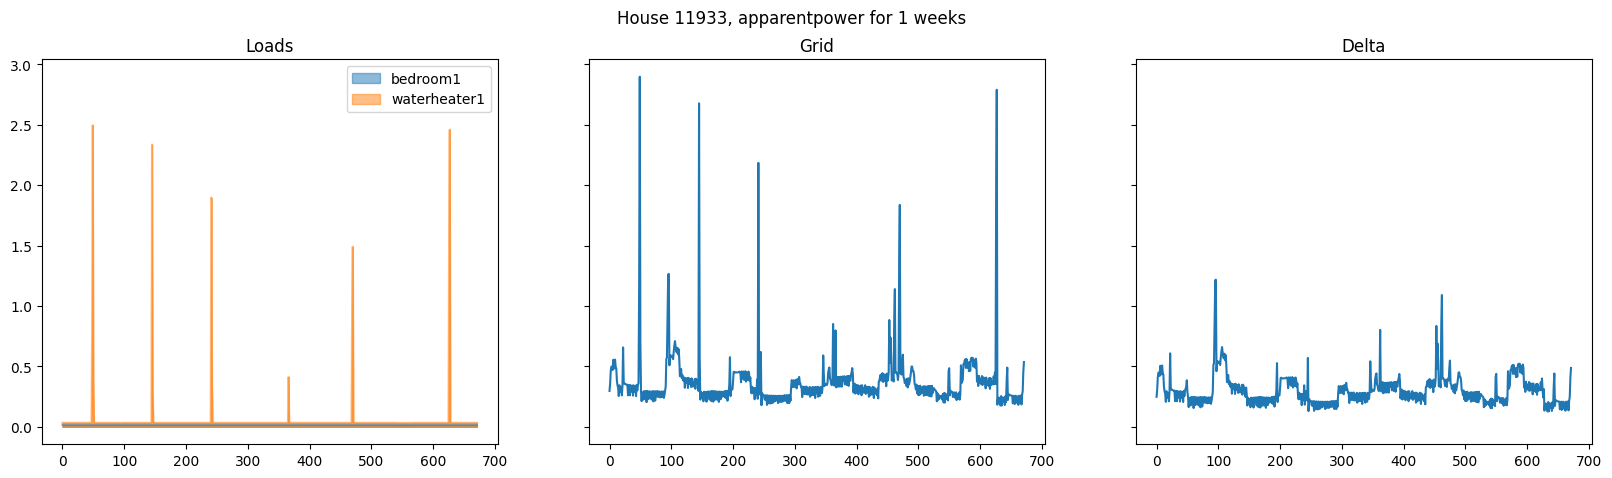

In [119]:
apparent__dataids = plot_houses(dataframes, 'apparentpower', 1)

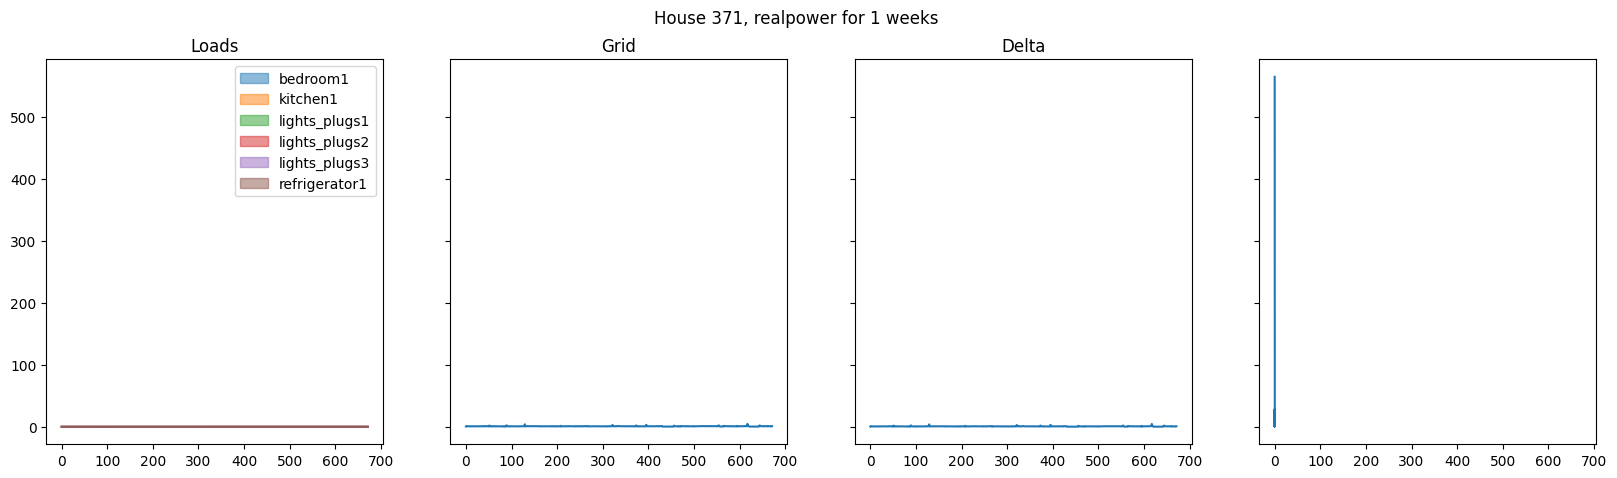

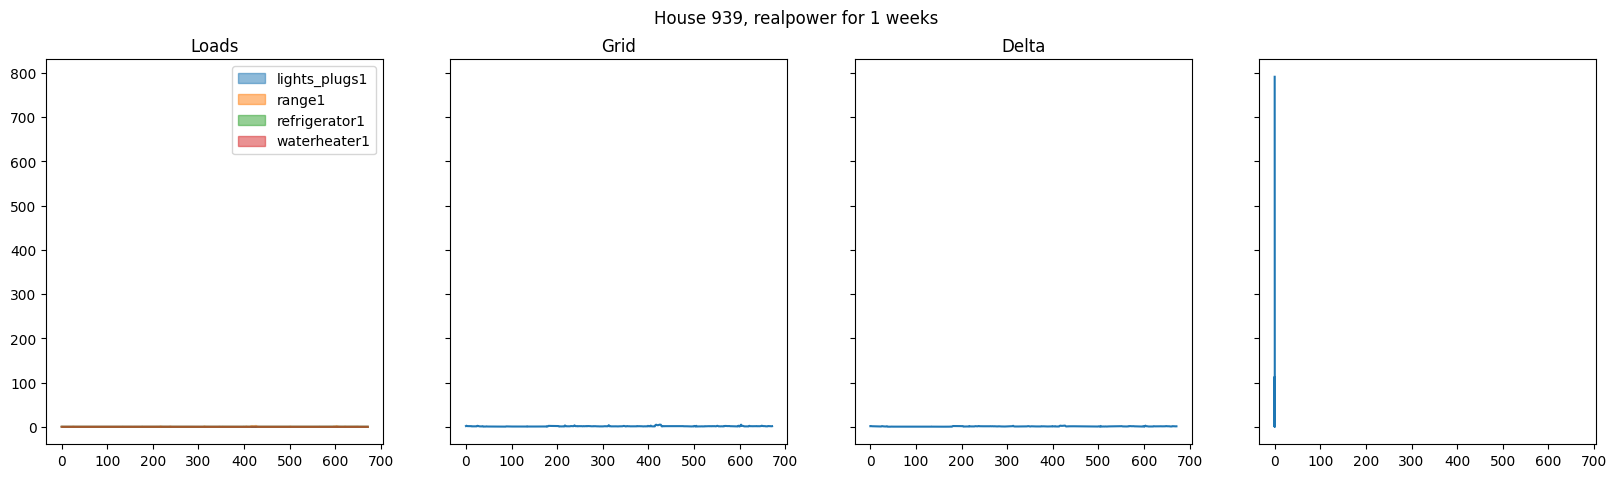

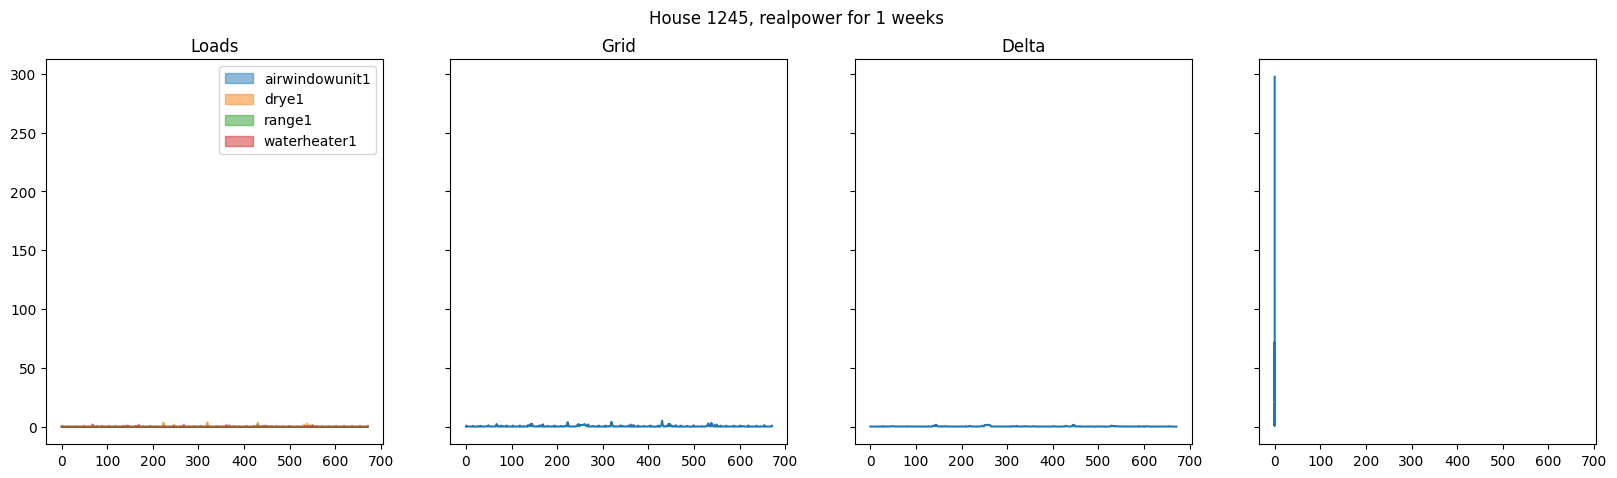

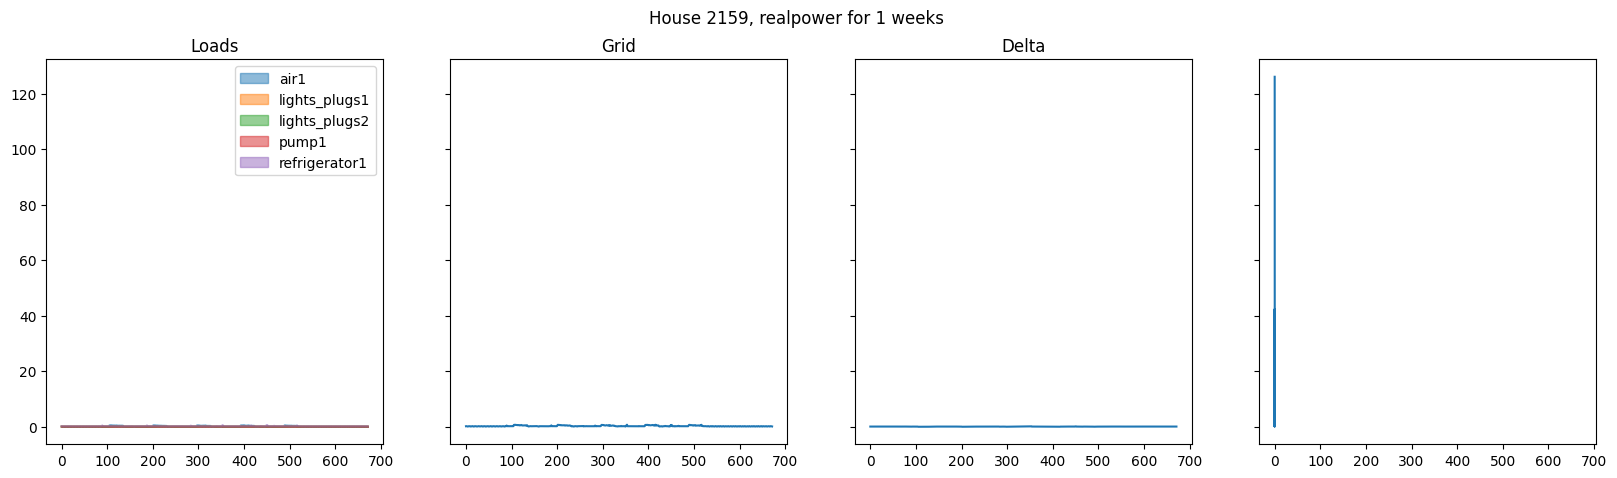

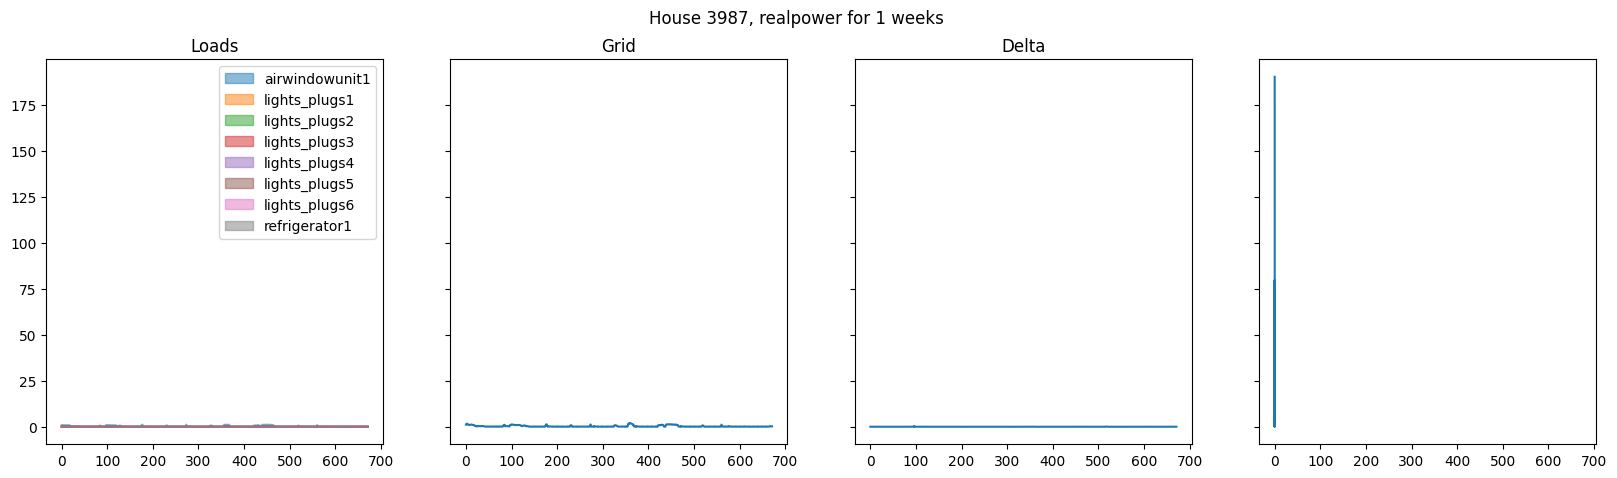

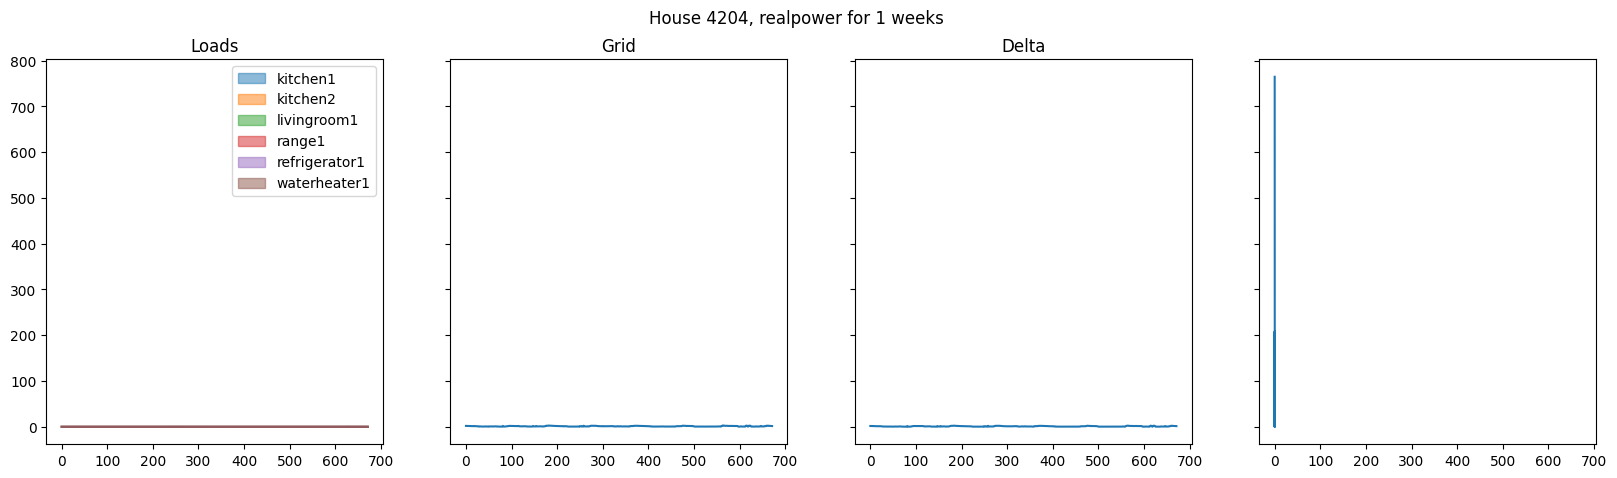

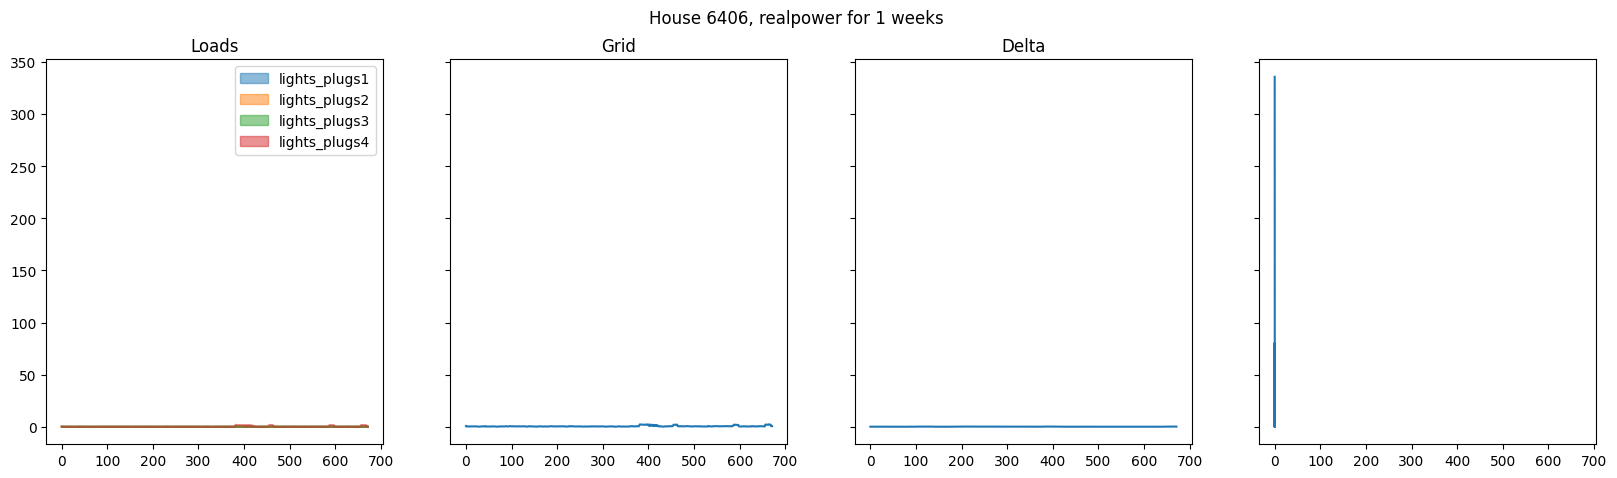

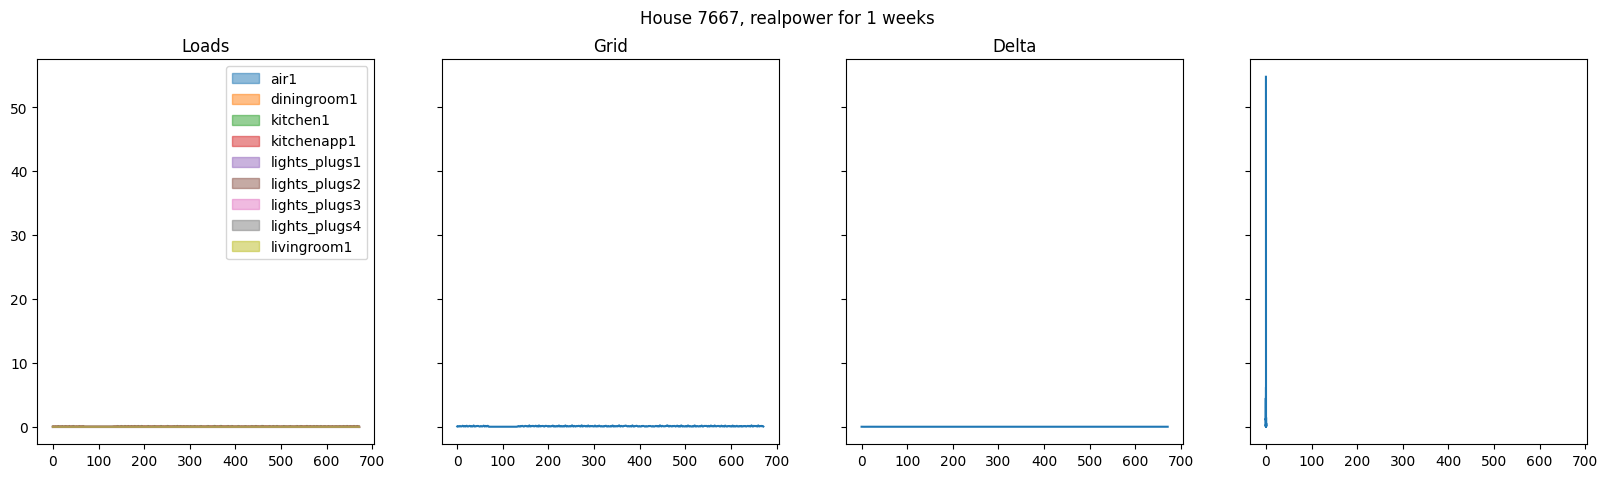

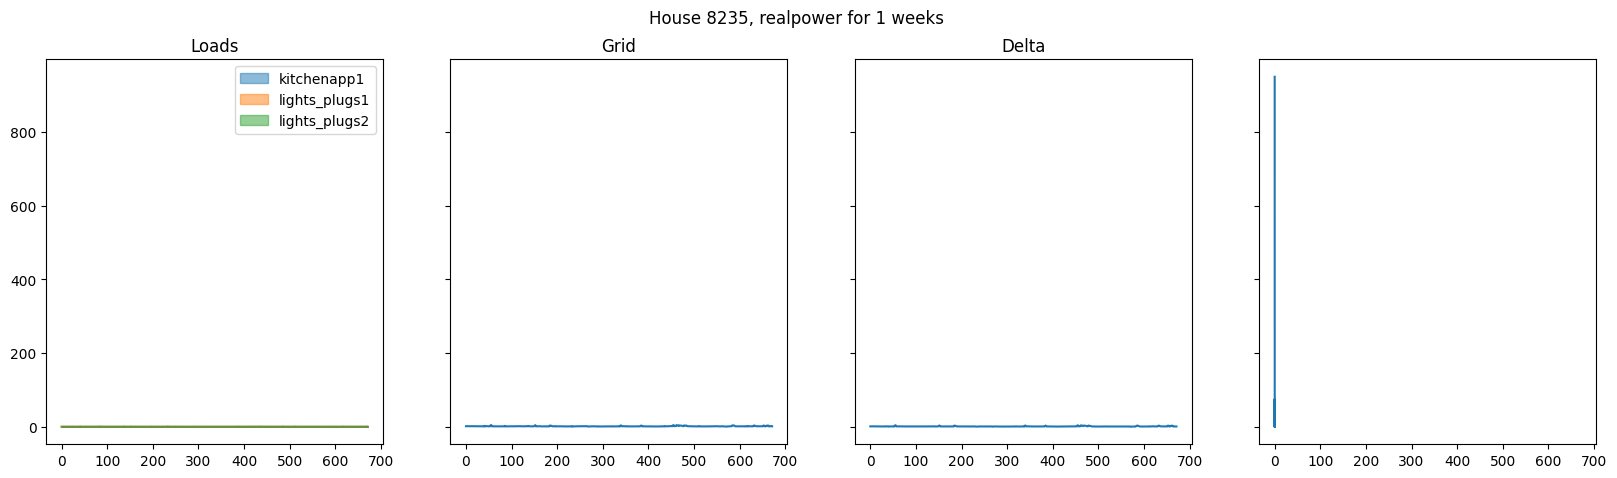

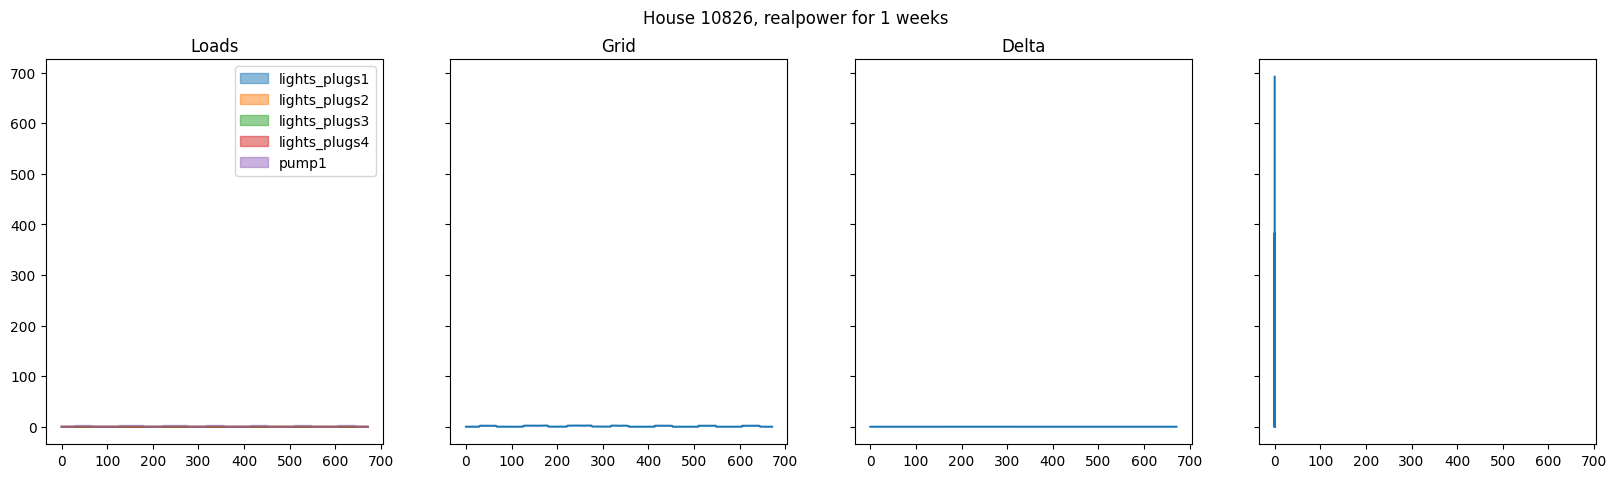

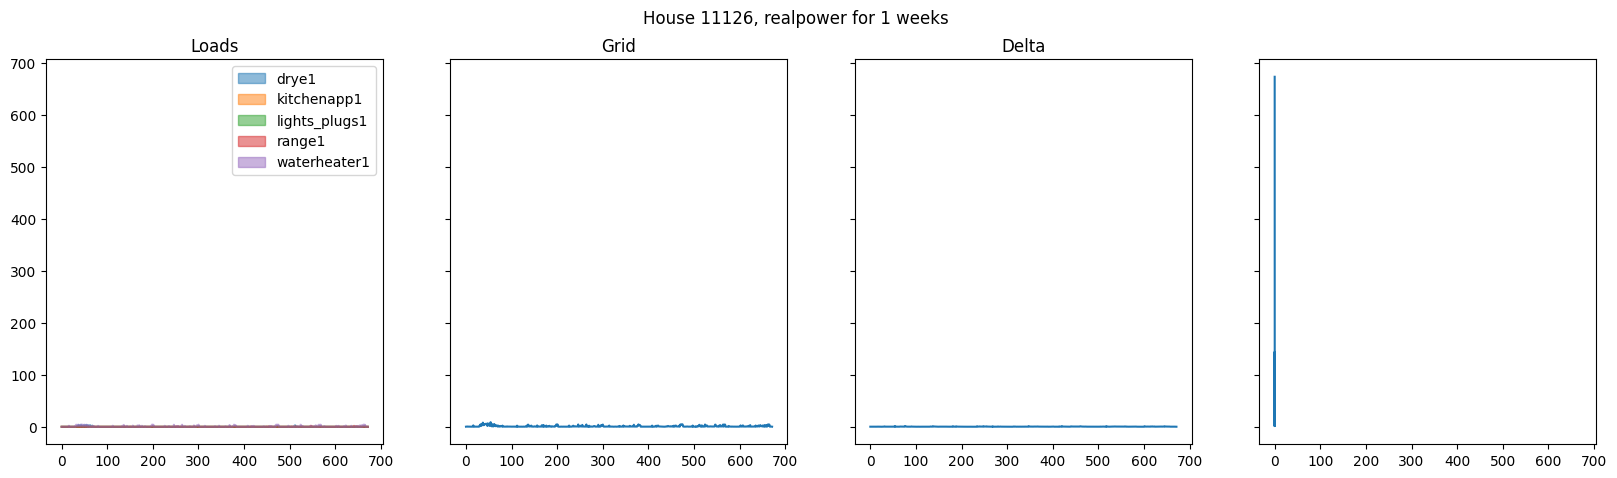

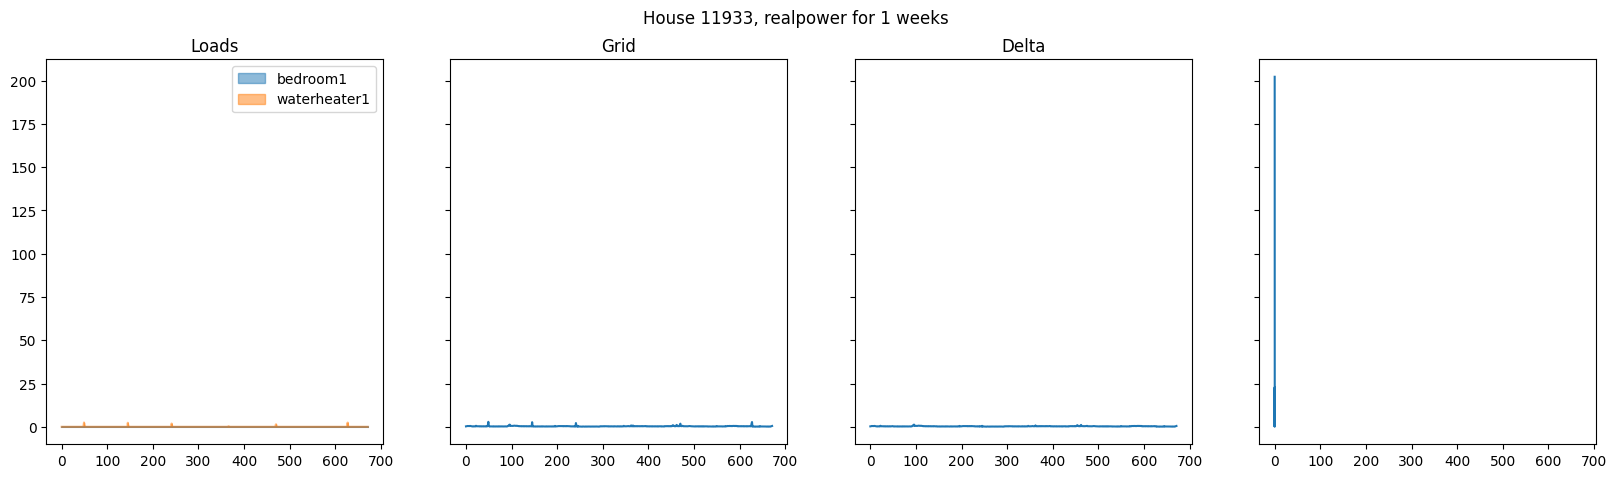

In [108]:
real__dataids = plot_houses(dataframes, 'realpower', 1)

In [15]:
dataids__intersect = set(real__dataids) & set(apparent__dataids)
dataids_diff = (set(real__dataids) | set(apparent__dataids)) - dataids__intersect

In [16]:
dataids_diff

{2006, 6056, 8997}

In [17]:
dataids__intersect

{371, 939, 1245, 2159, 3987, 4204, 6406, 7667, 8235, 10826, 11126, 11933}

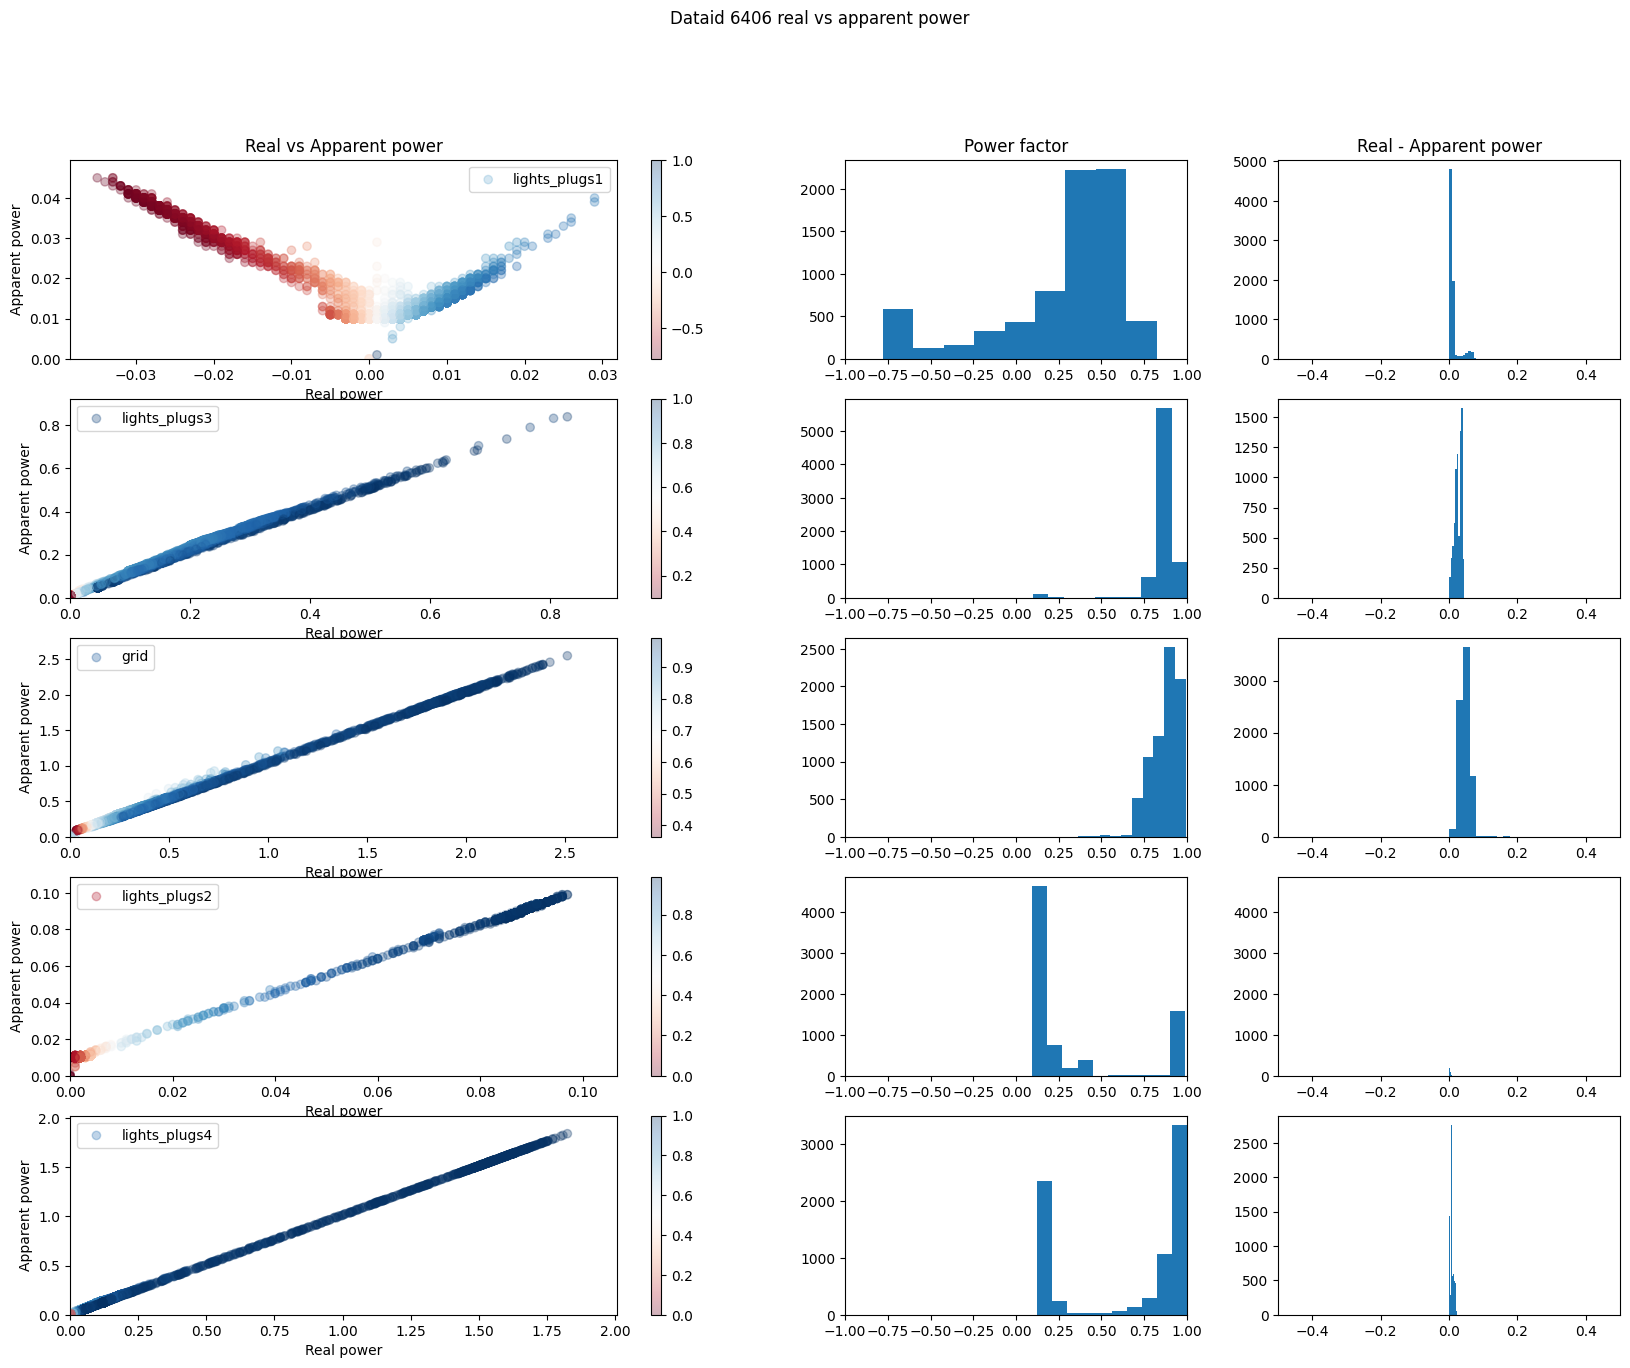

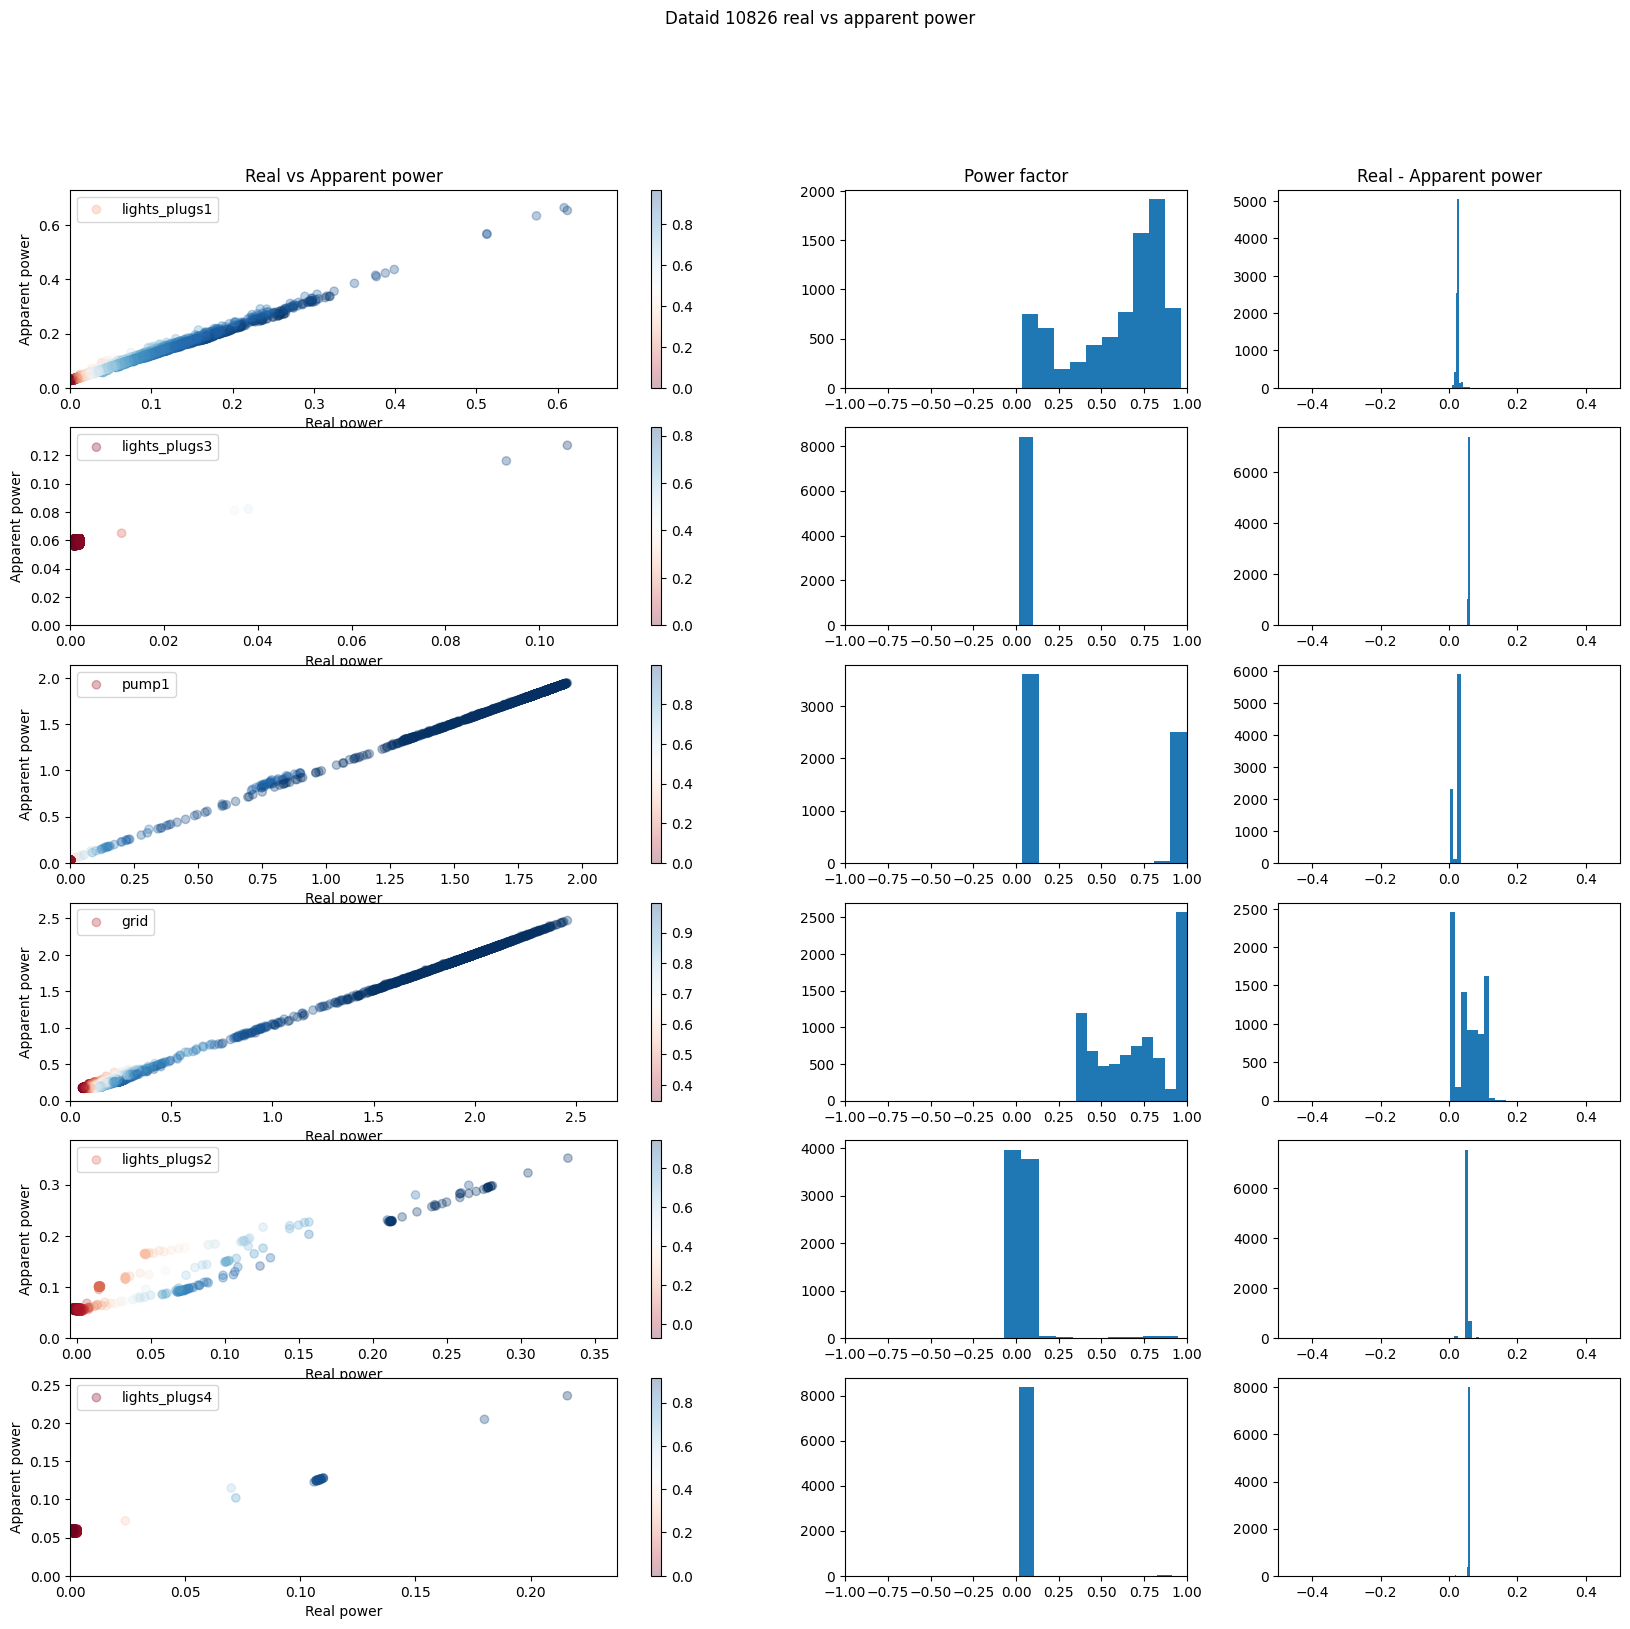

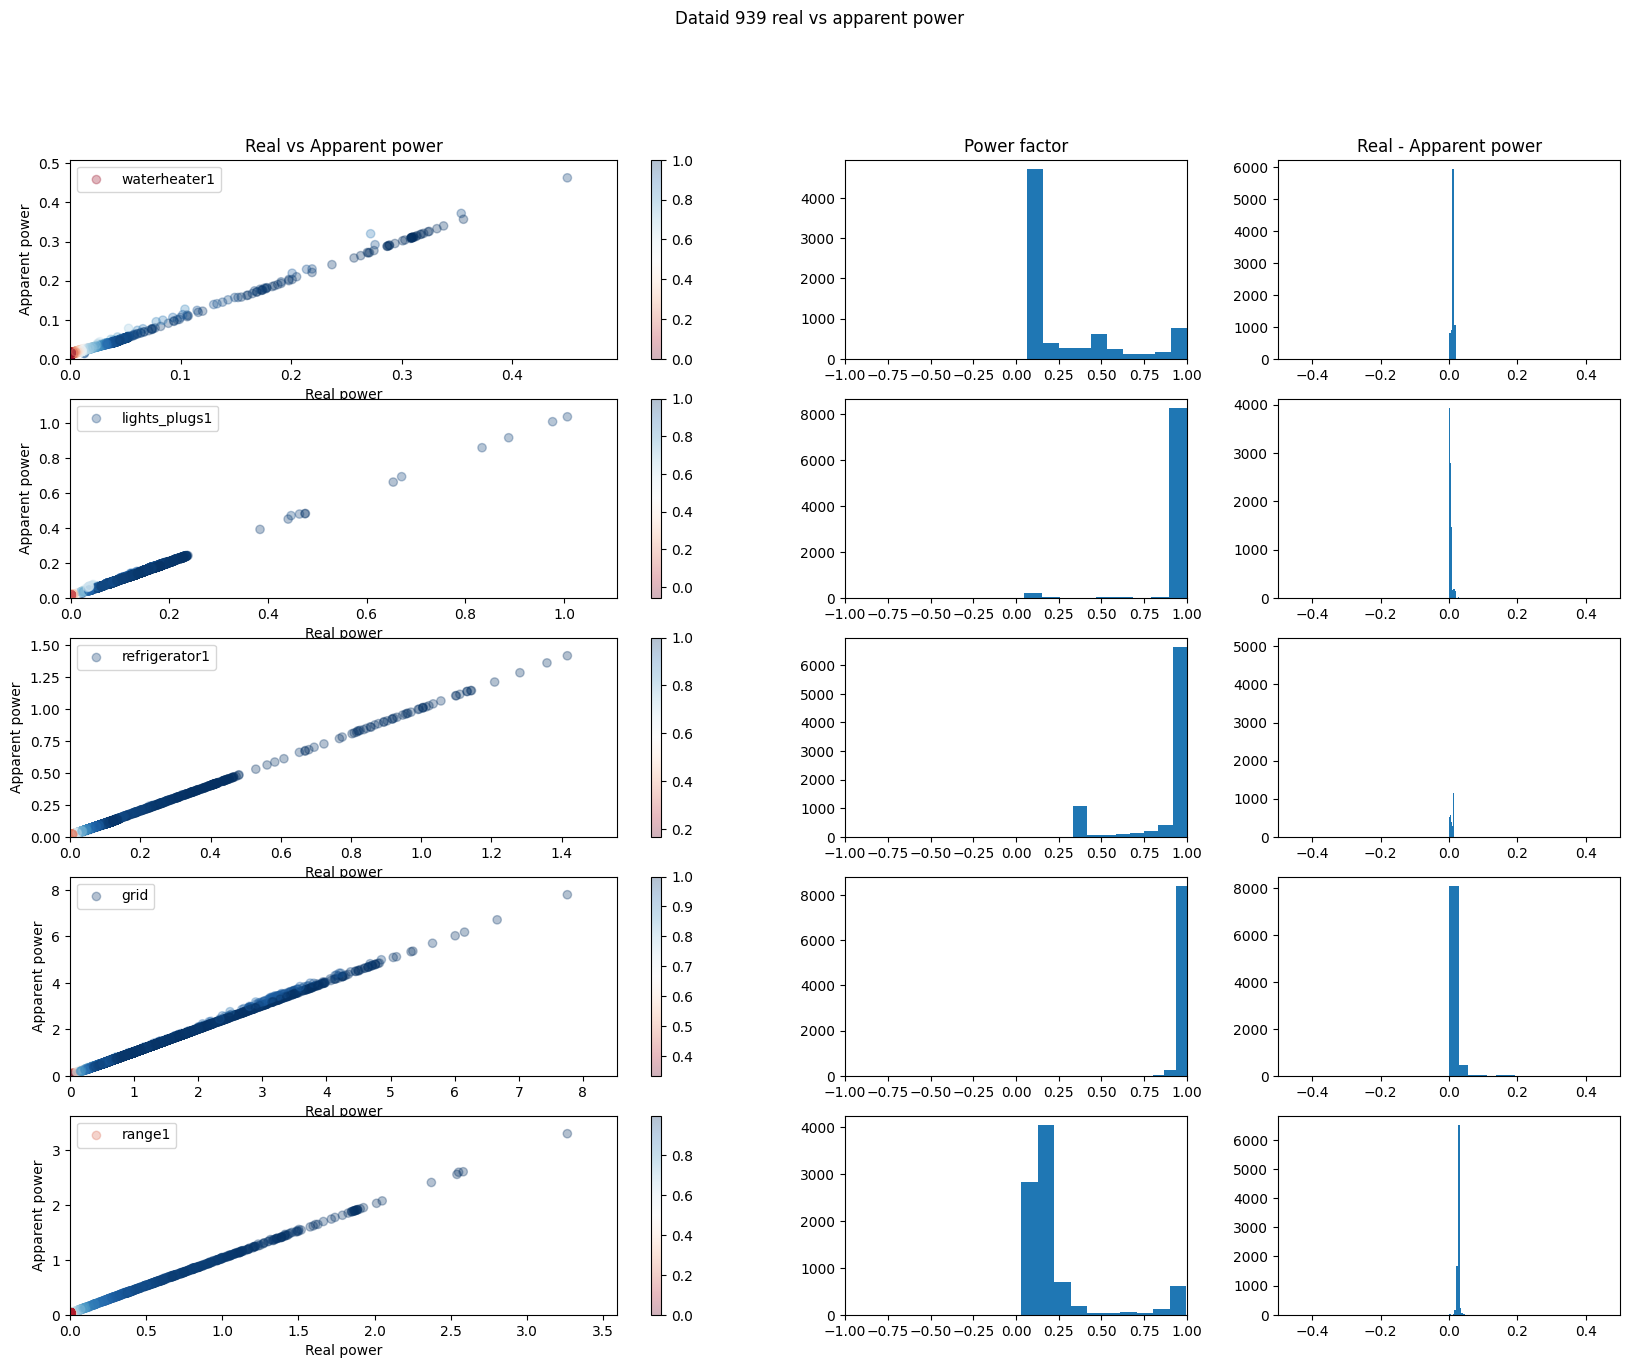

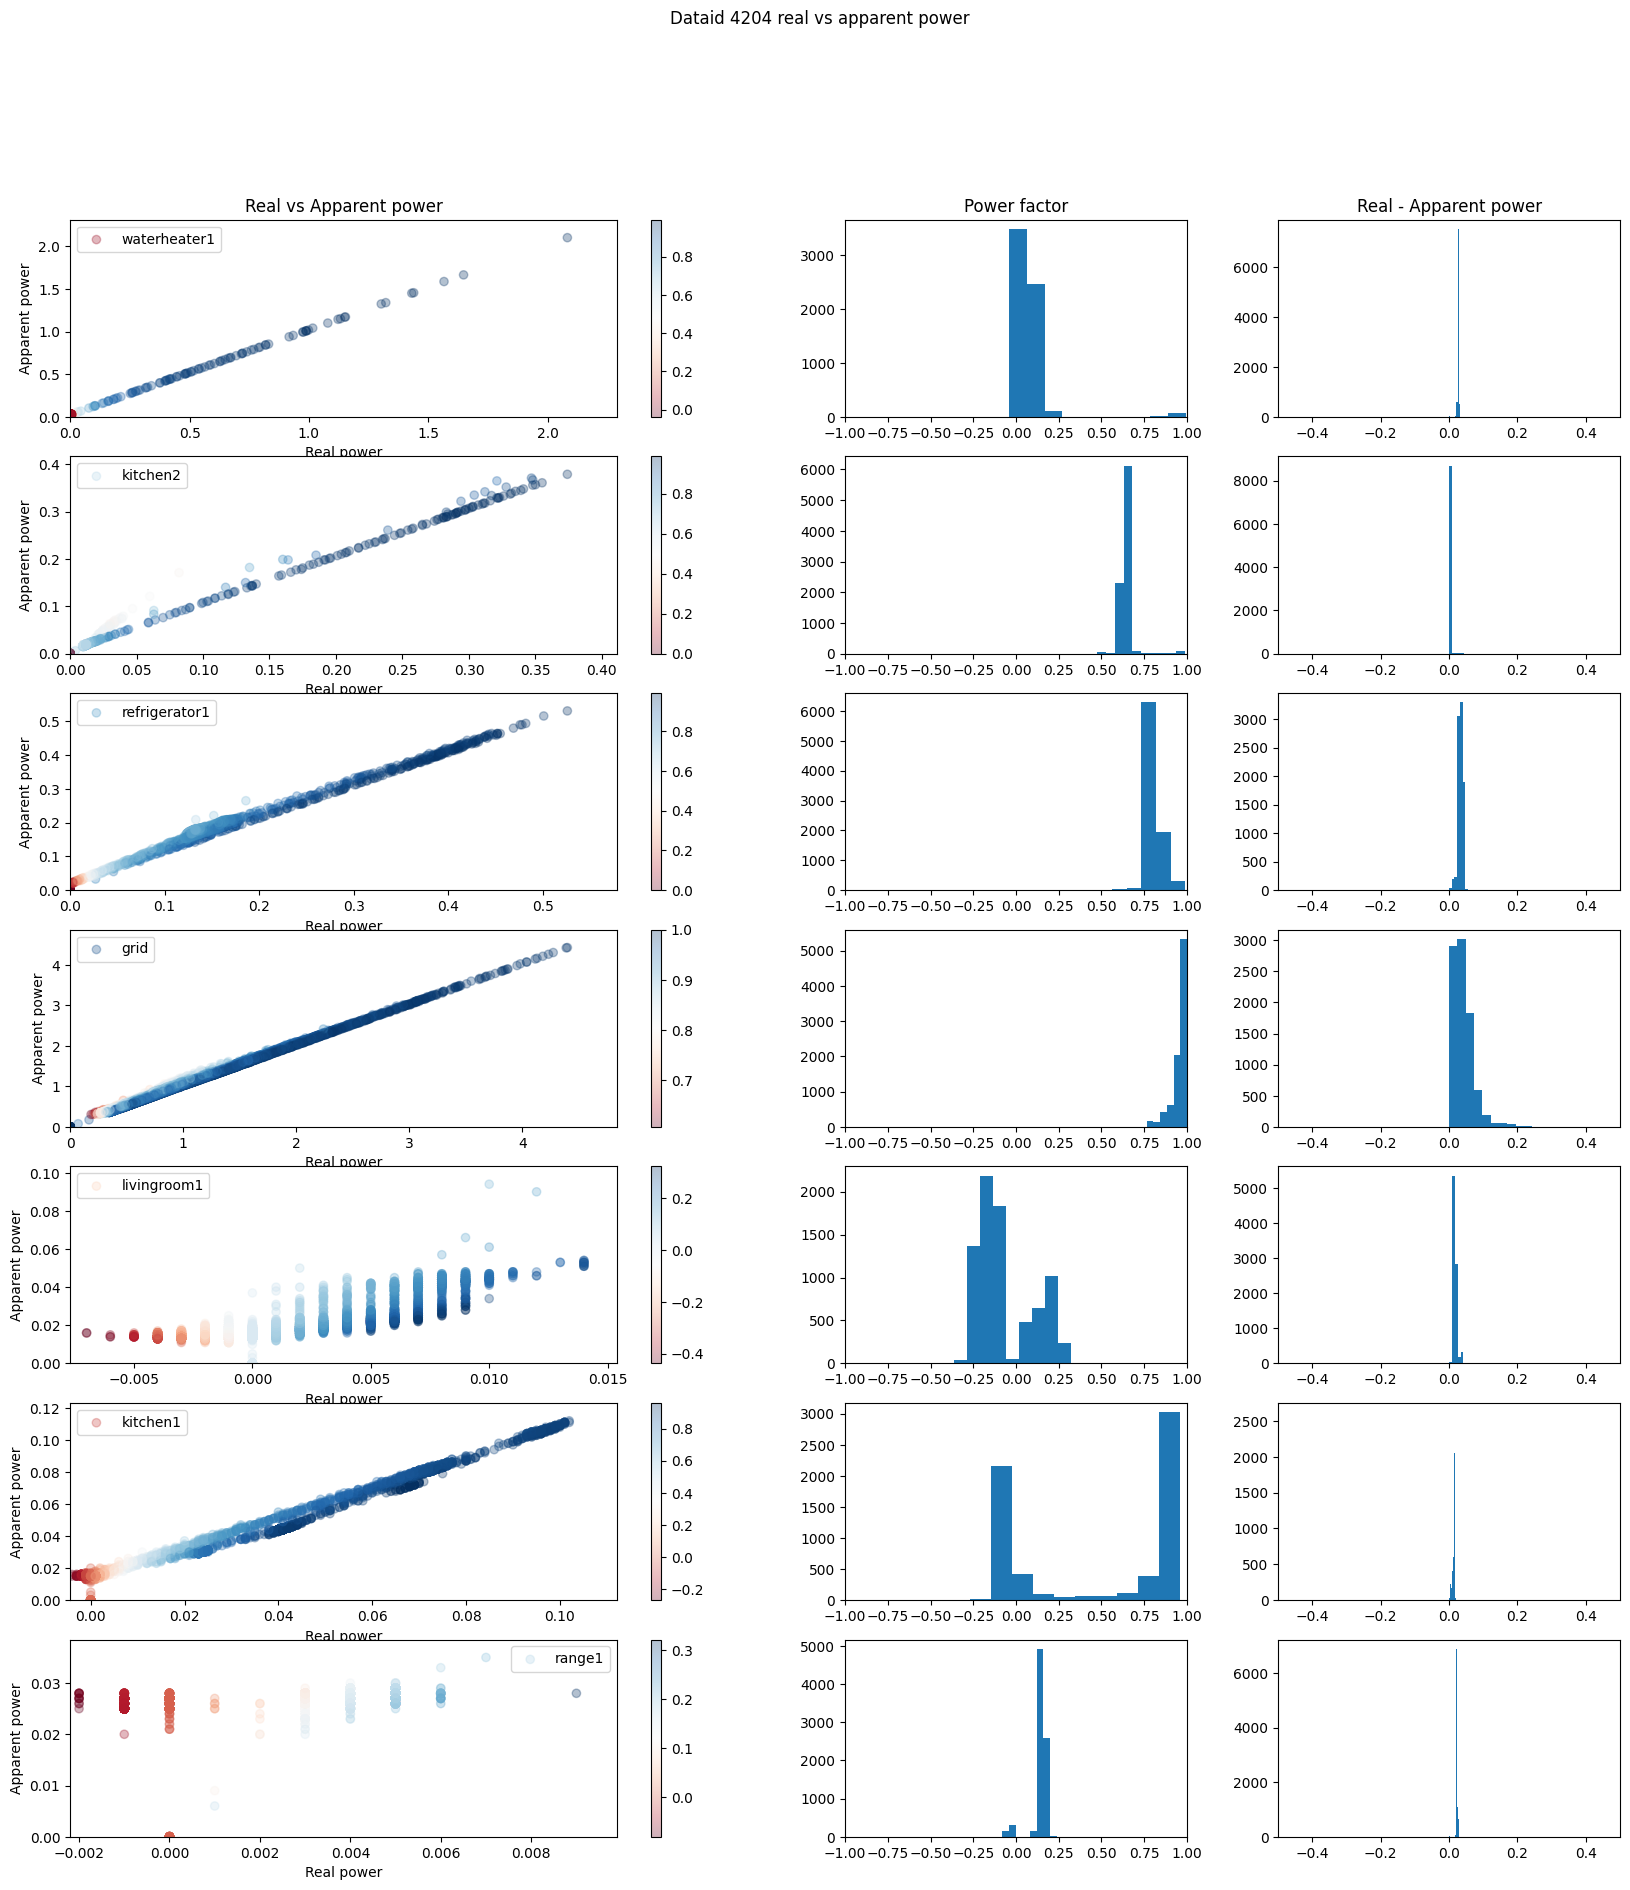

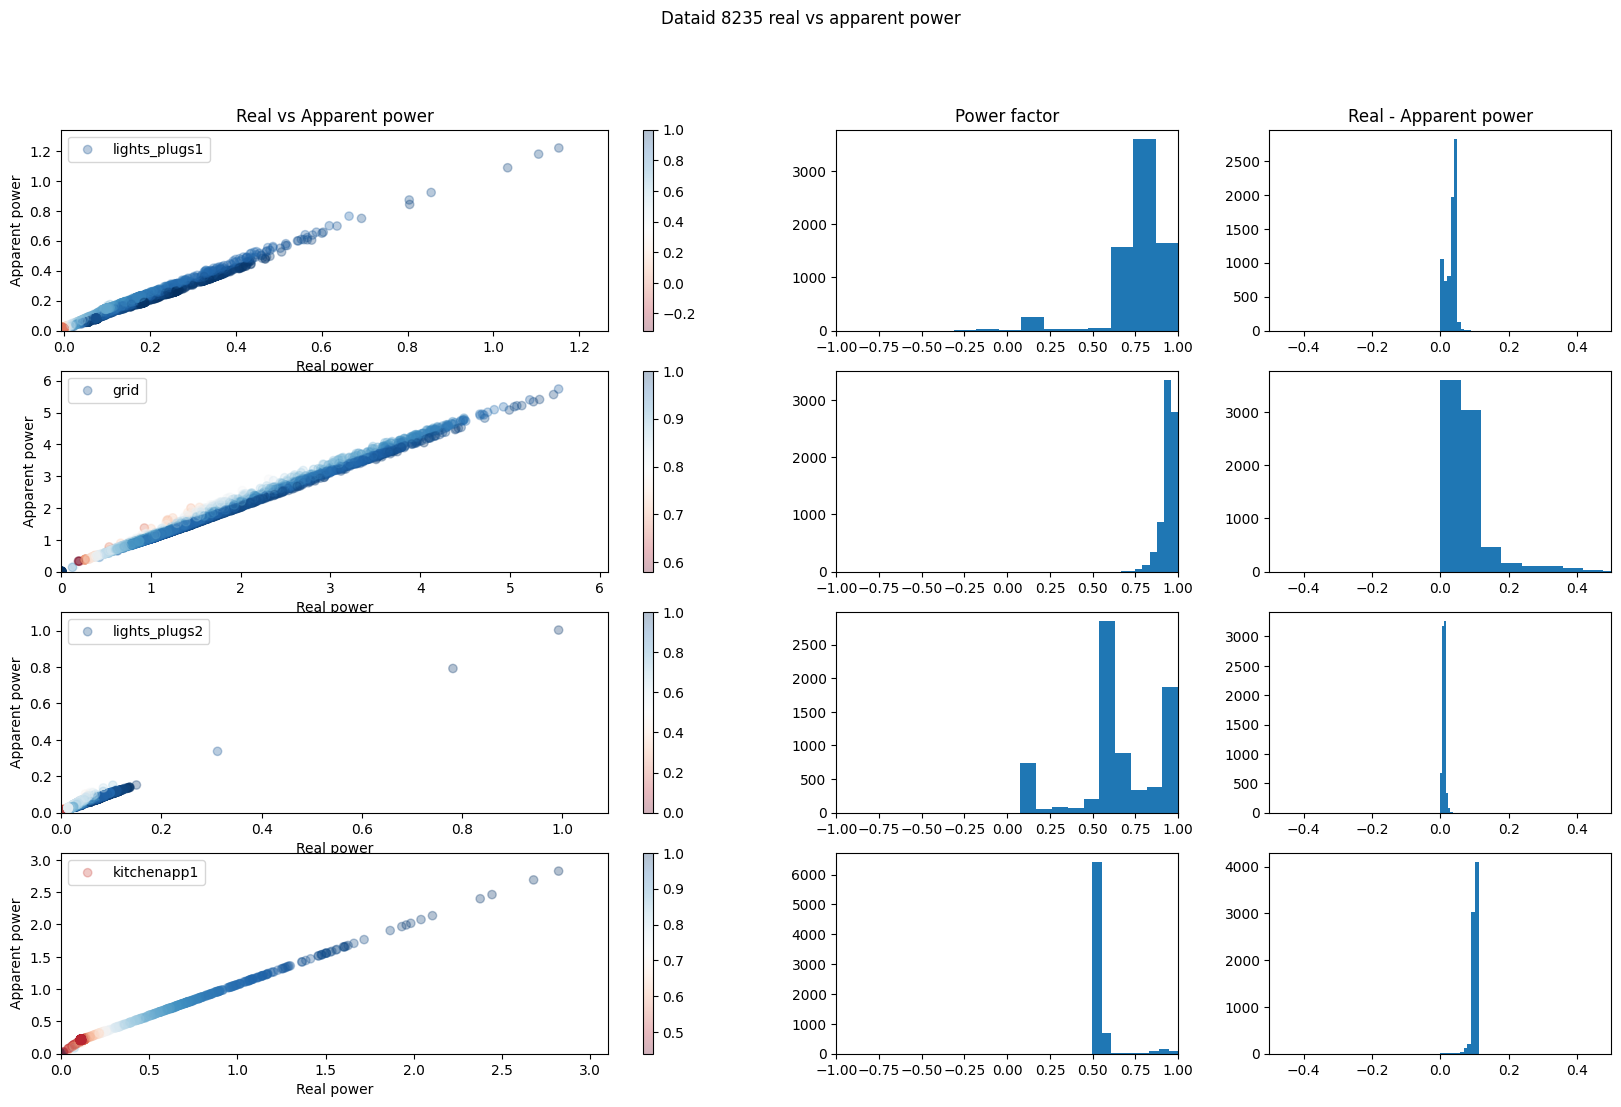

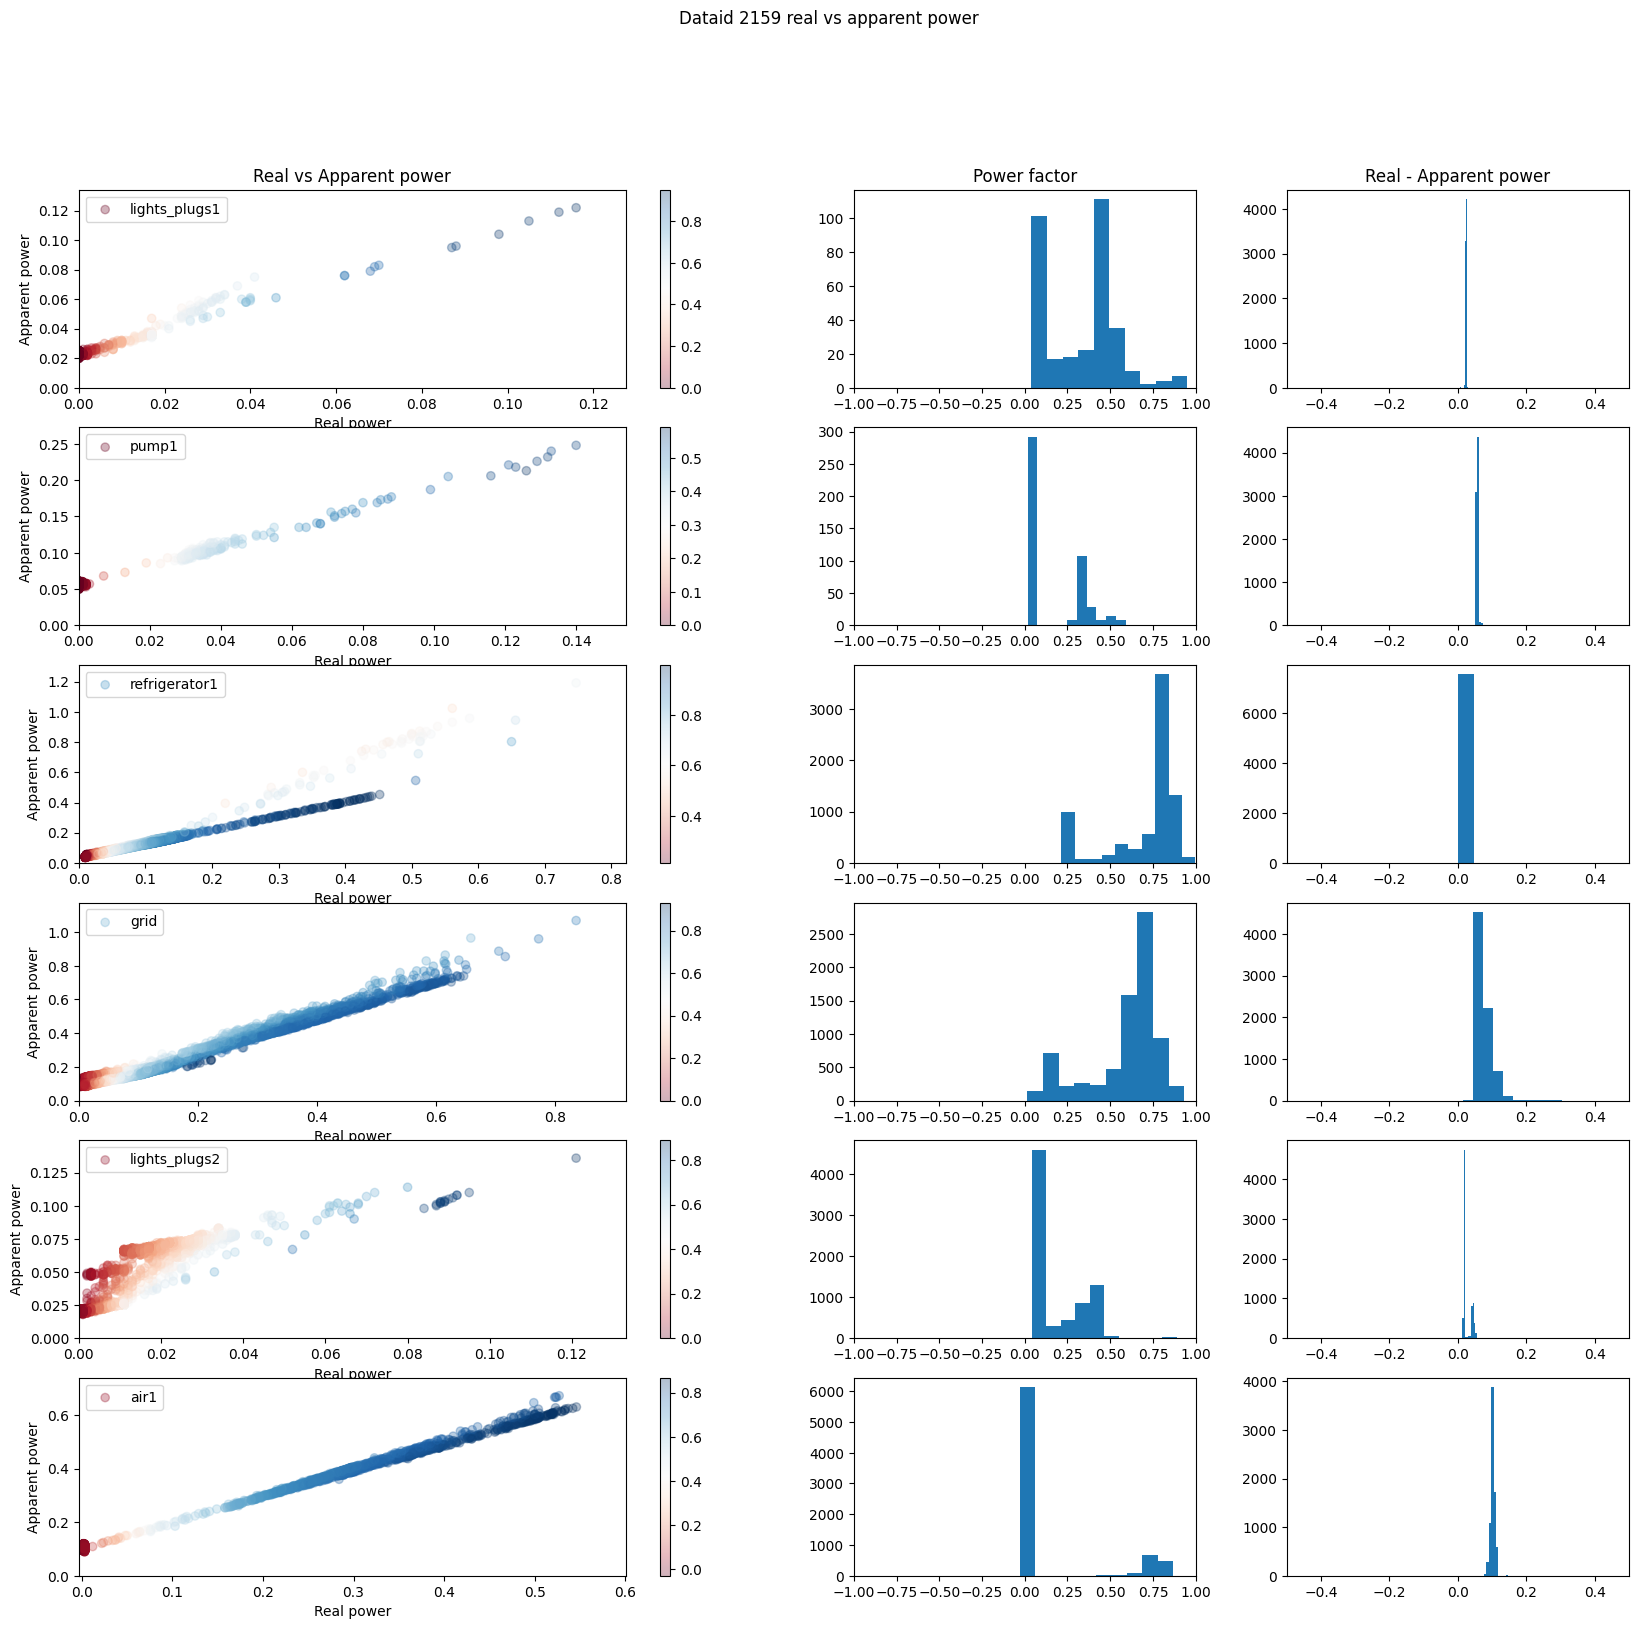

'lights_plugs3#apparent'
'lights_plugs2#apparent'


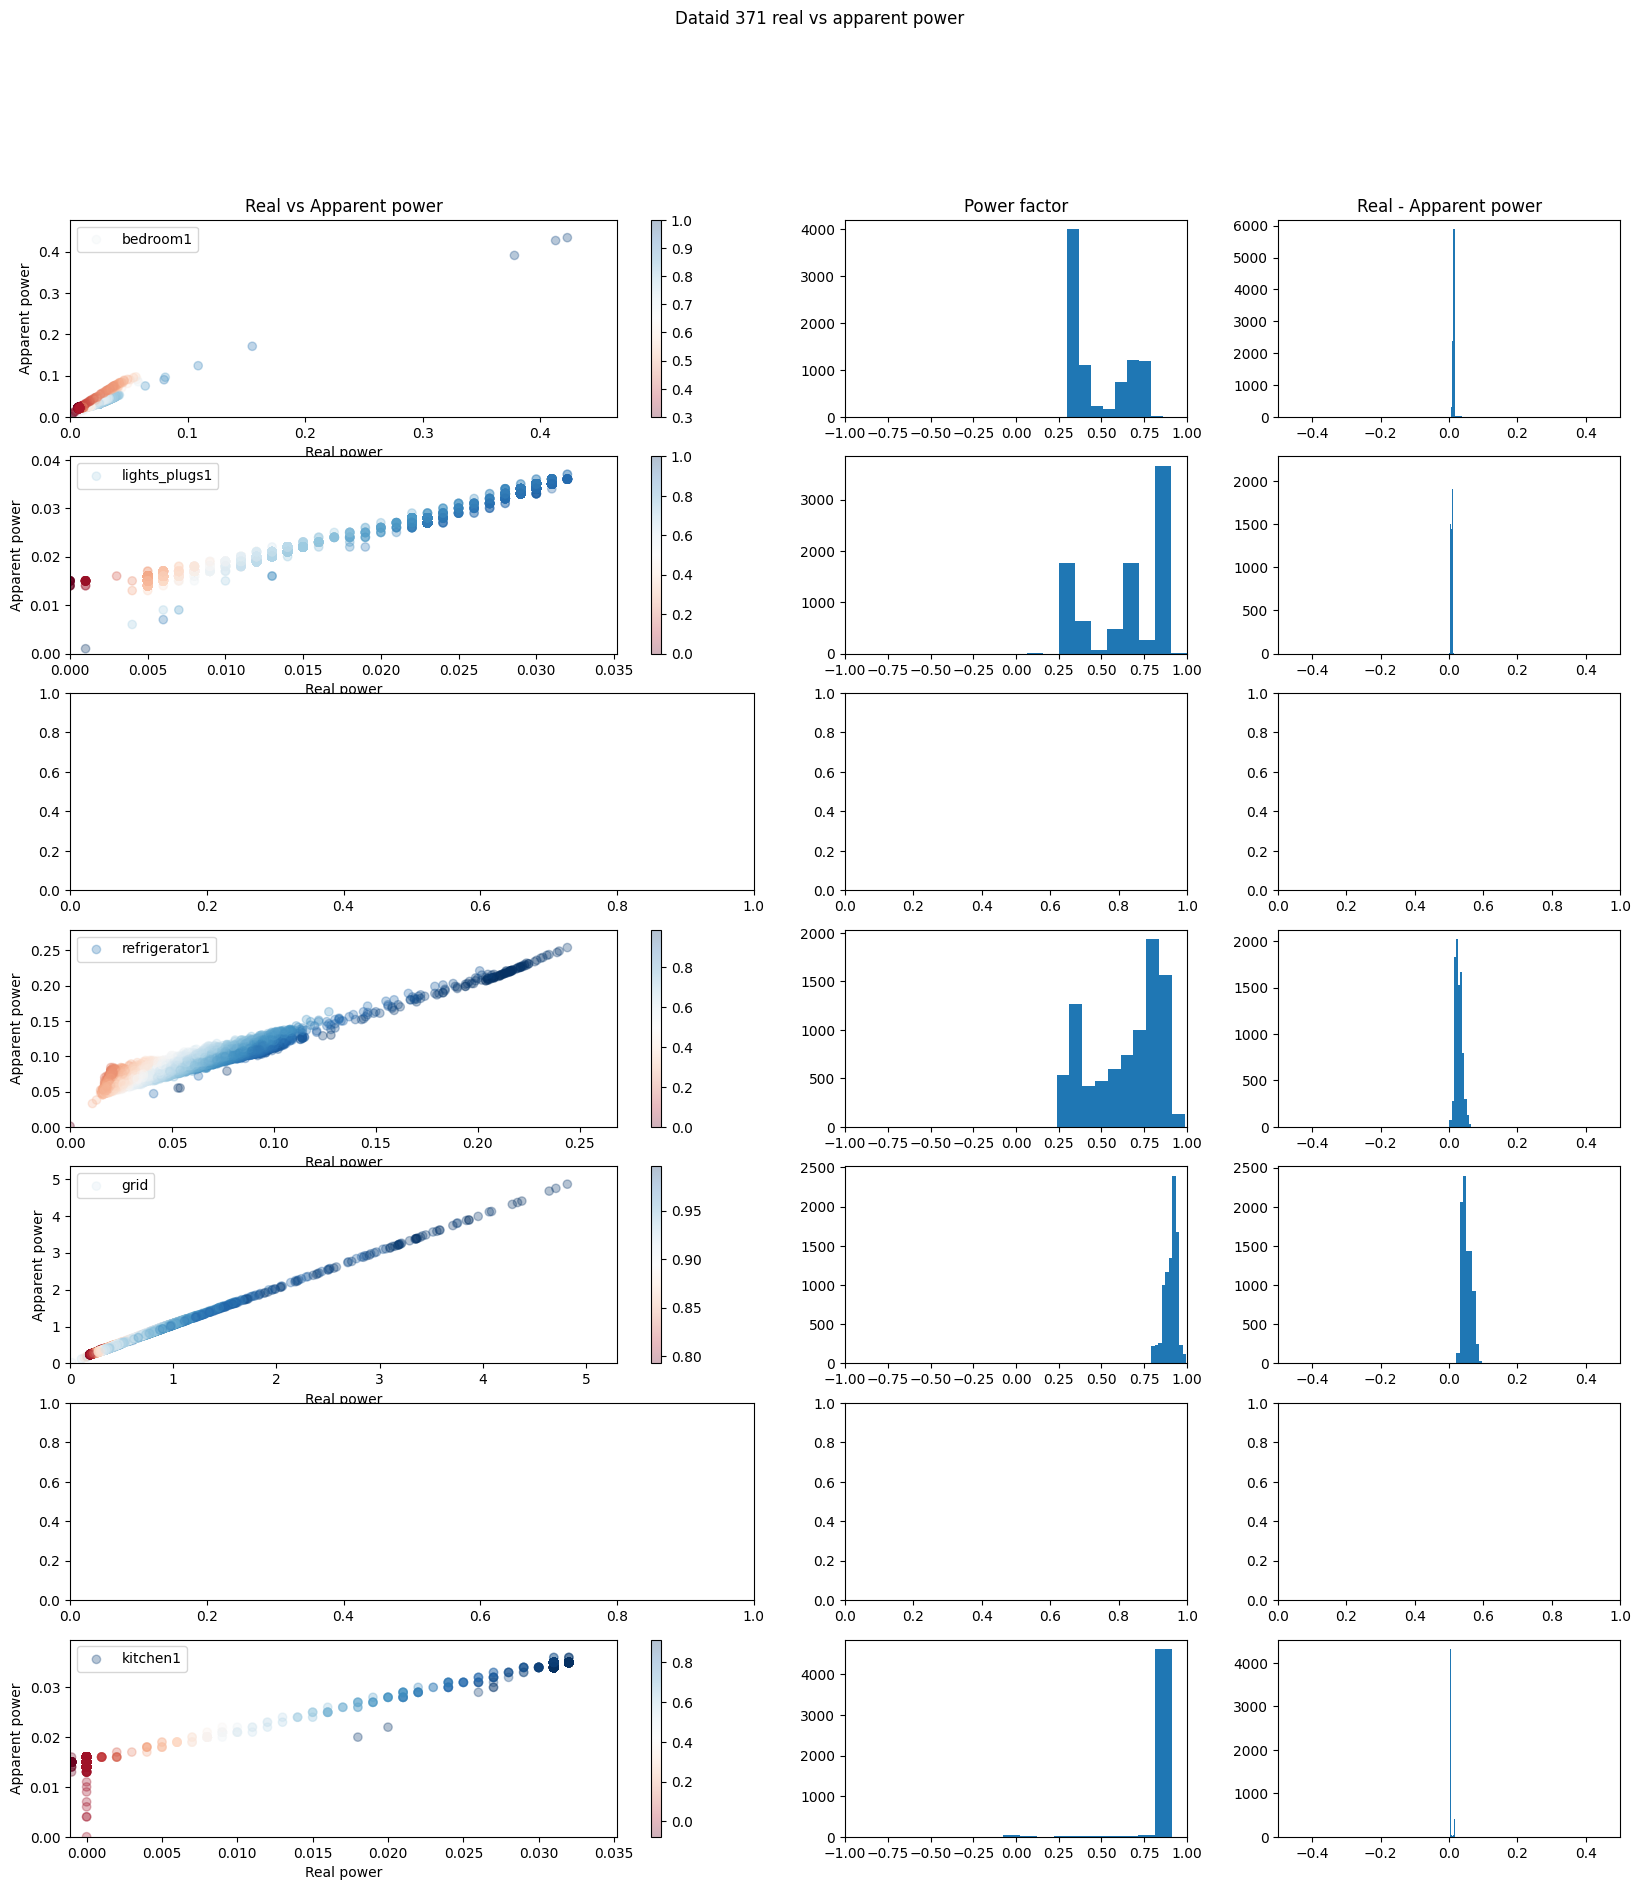

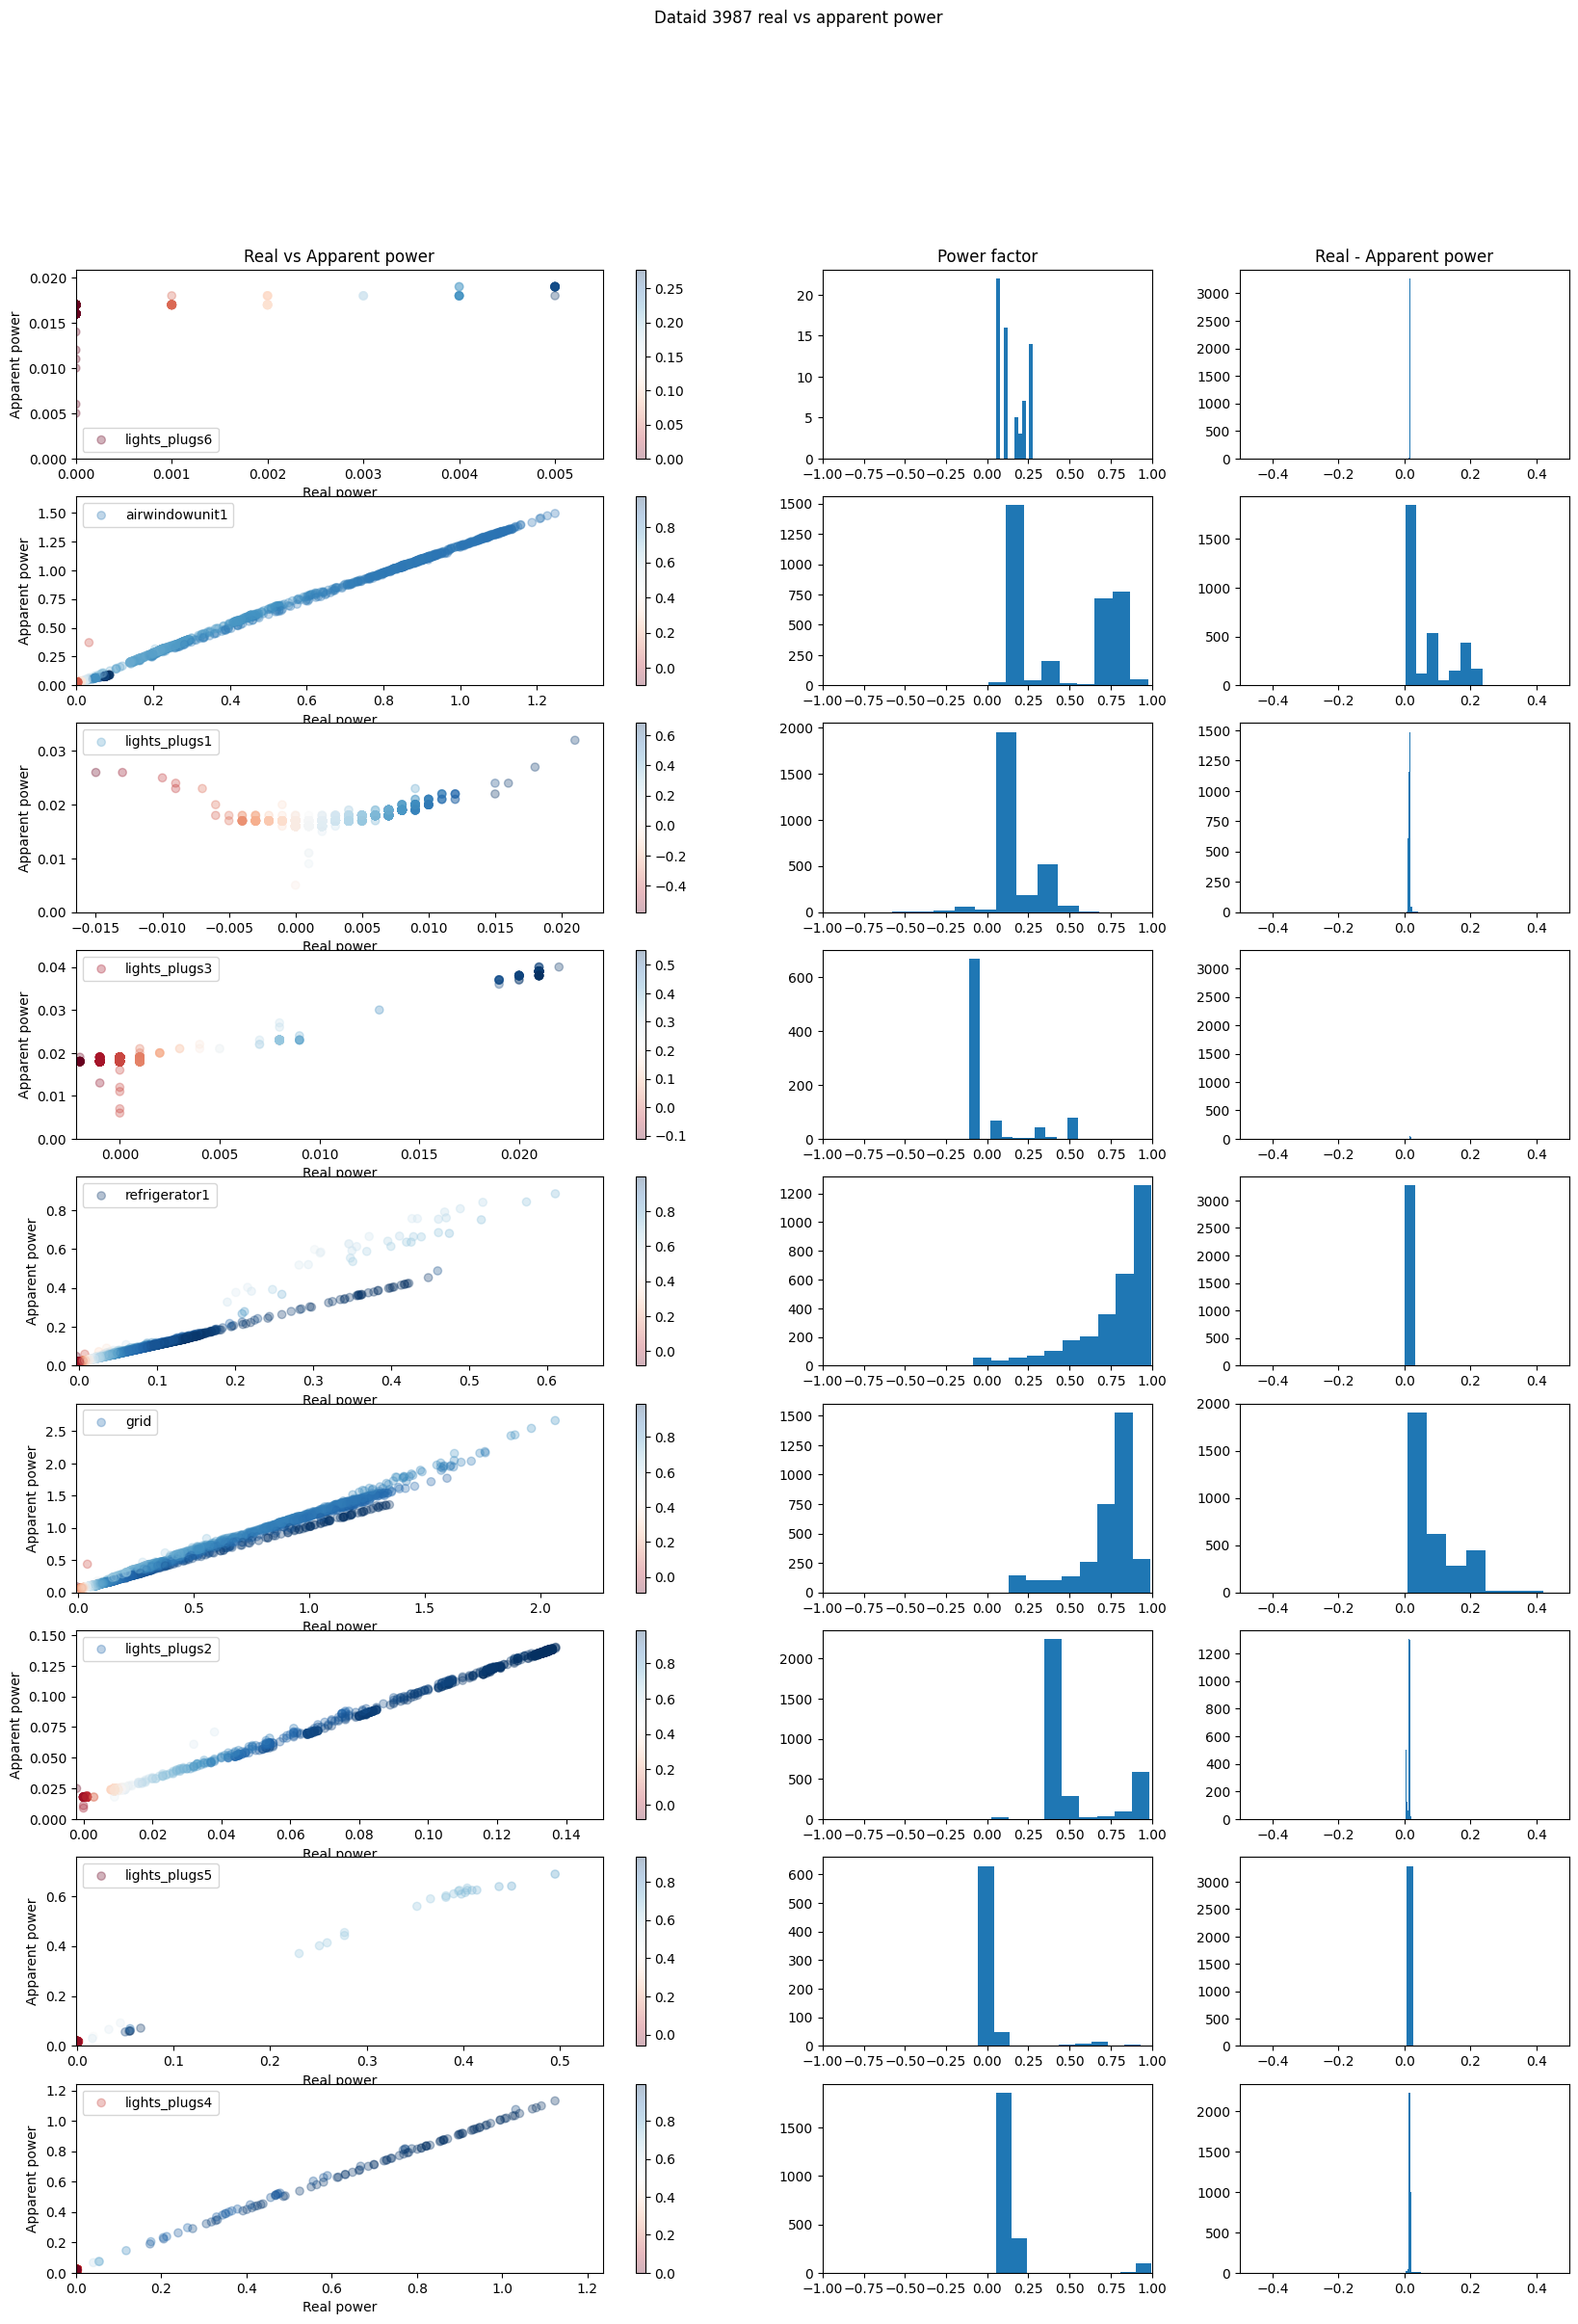

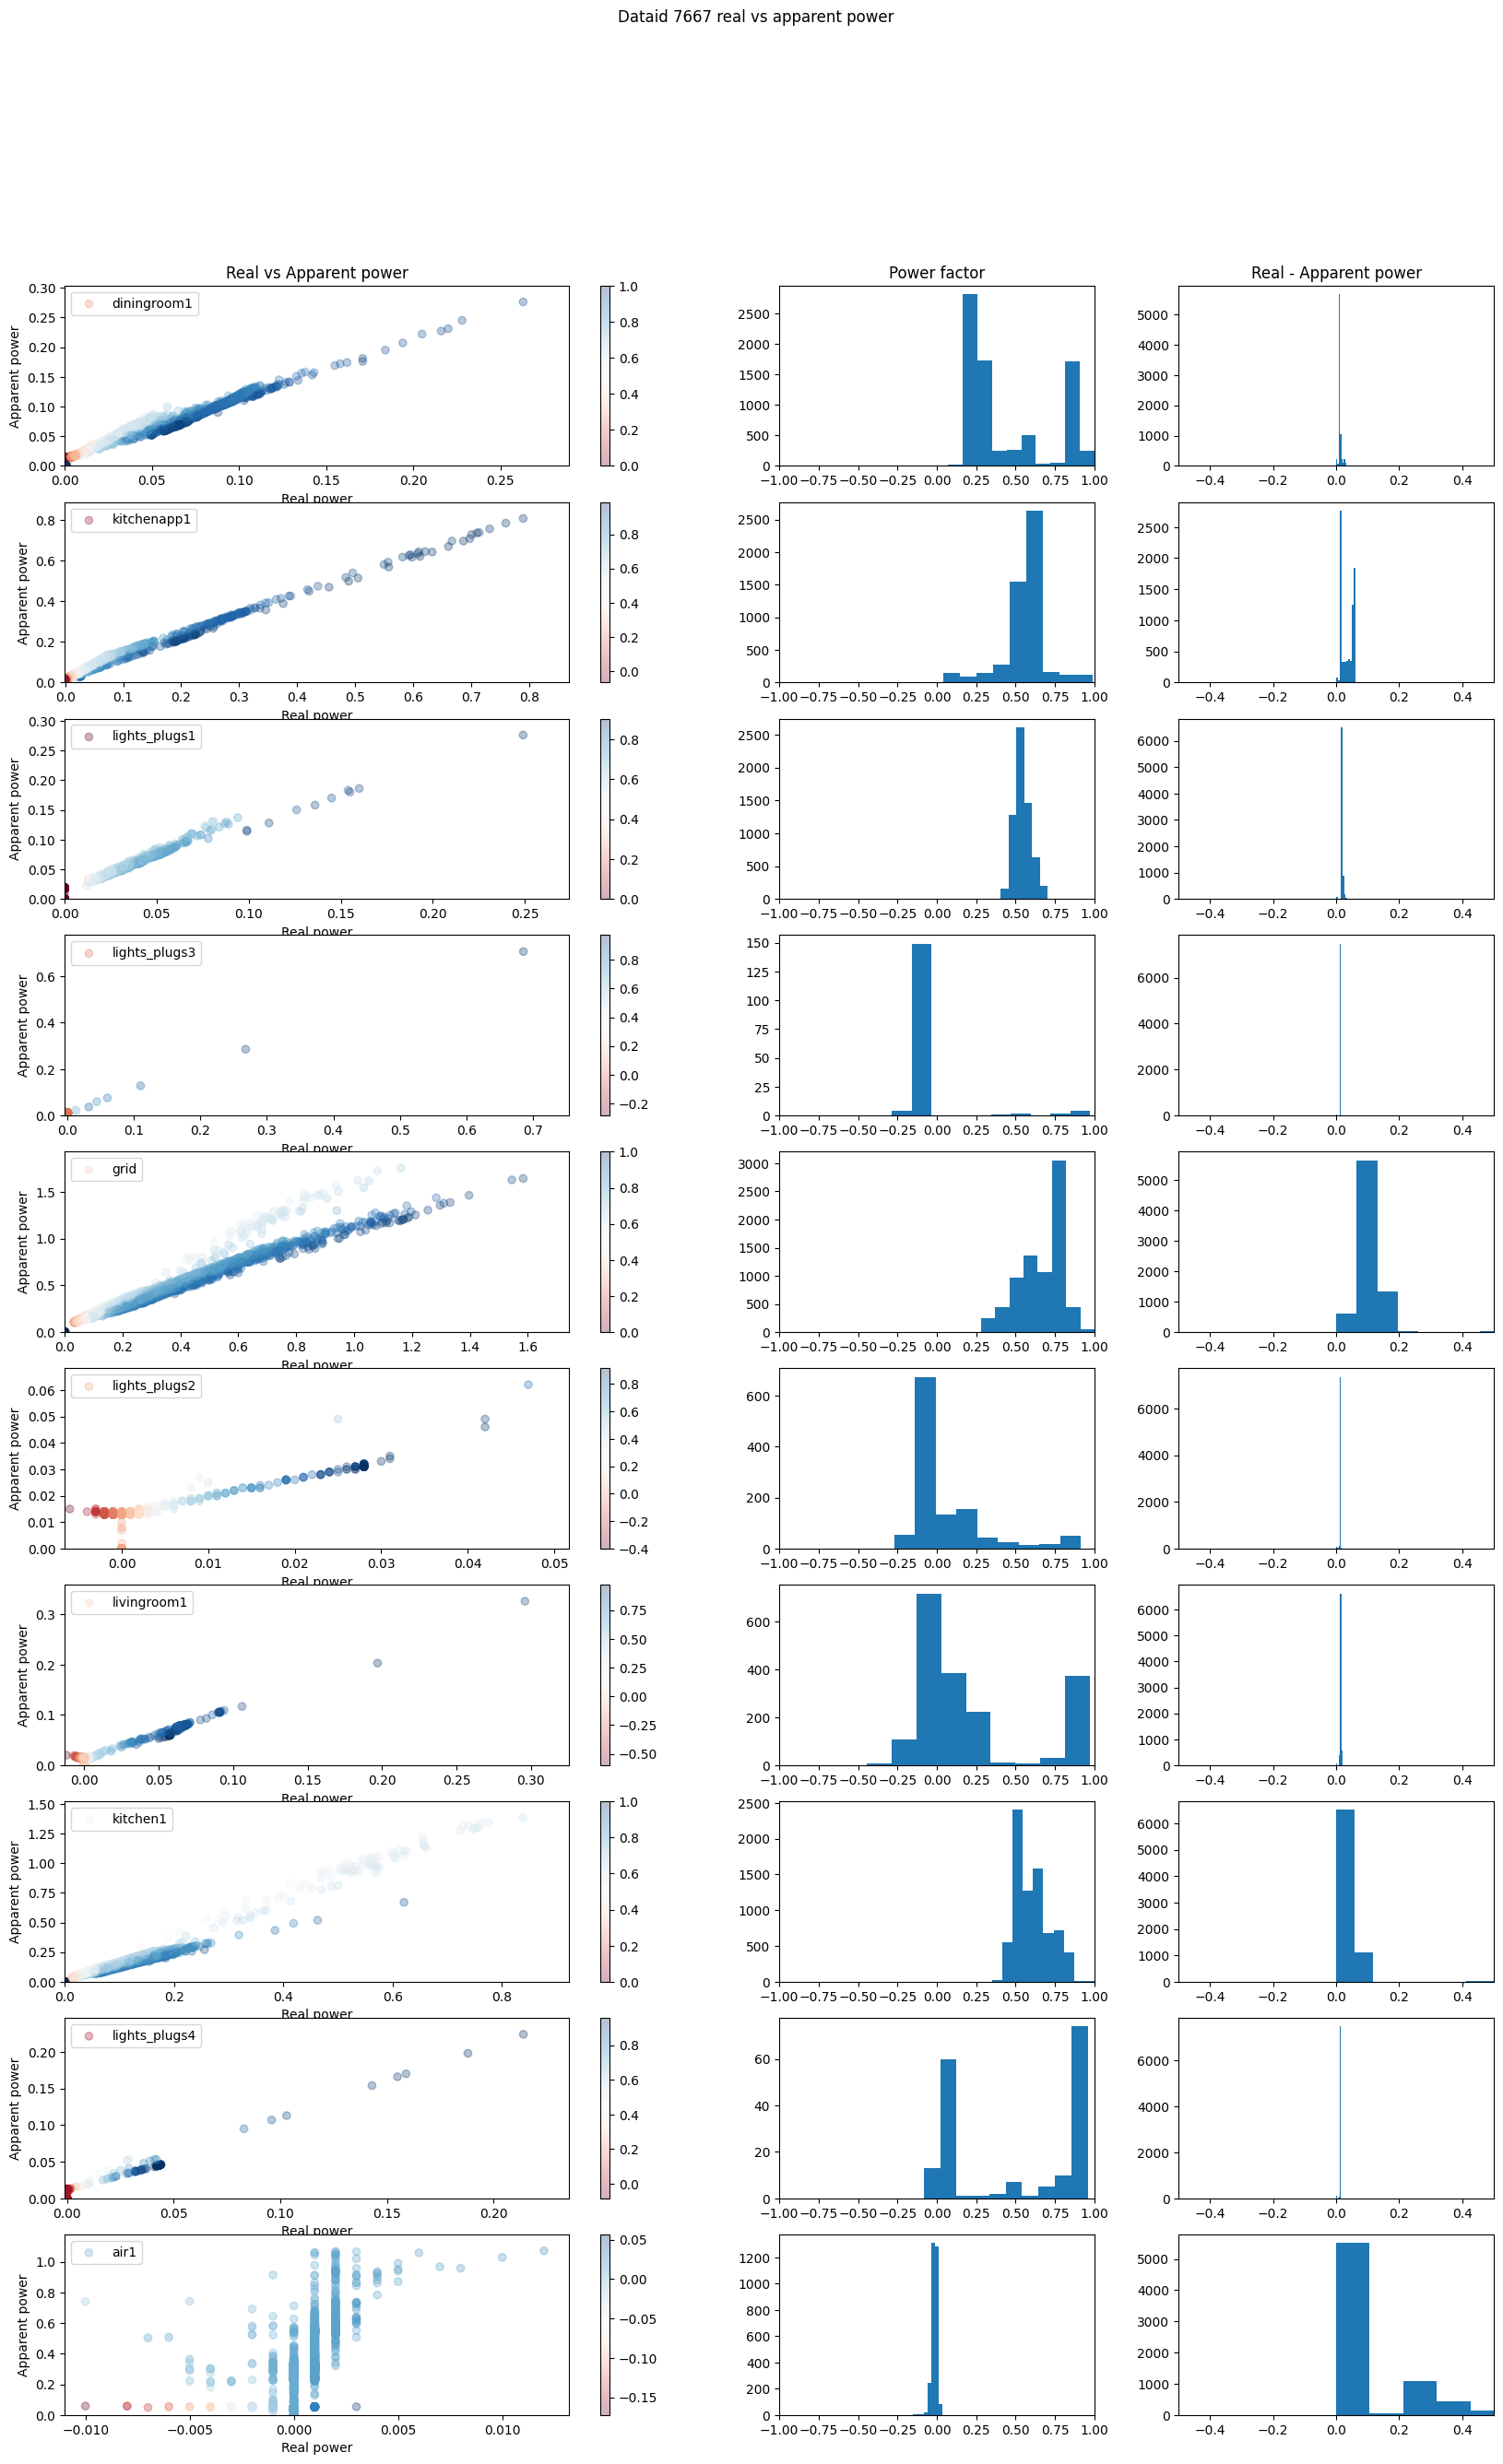

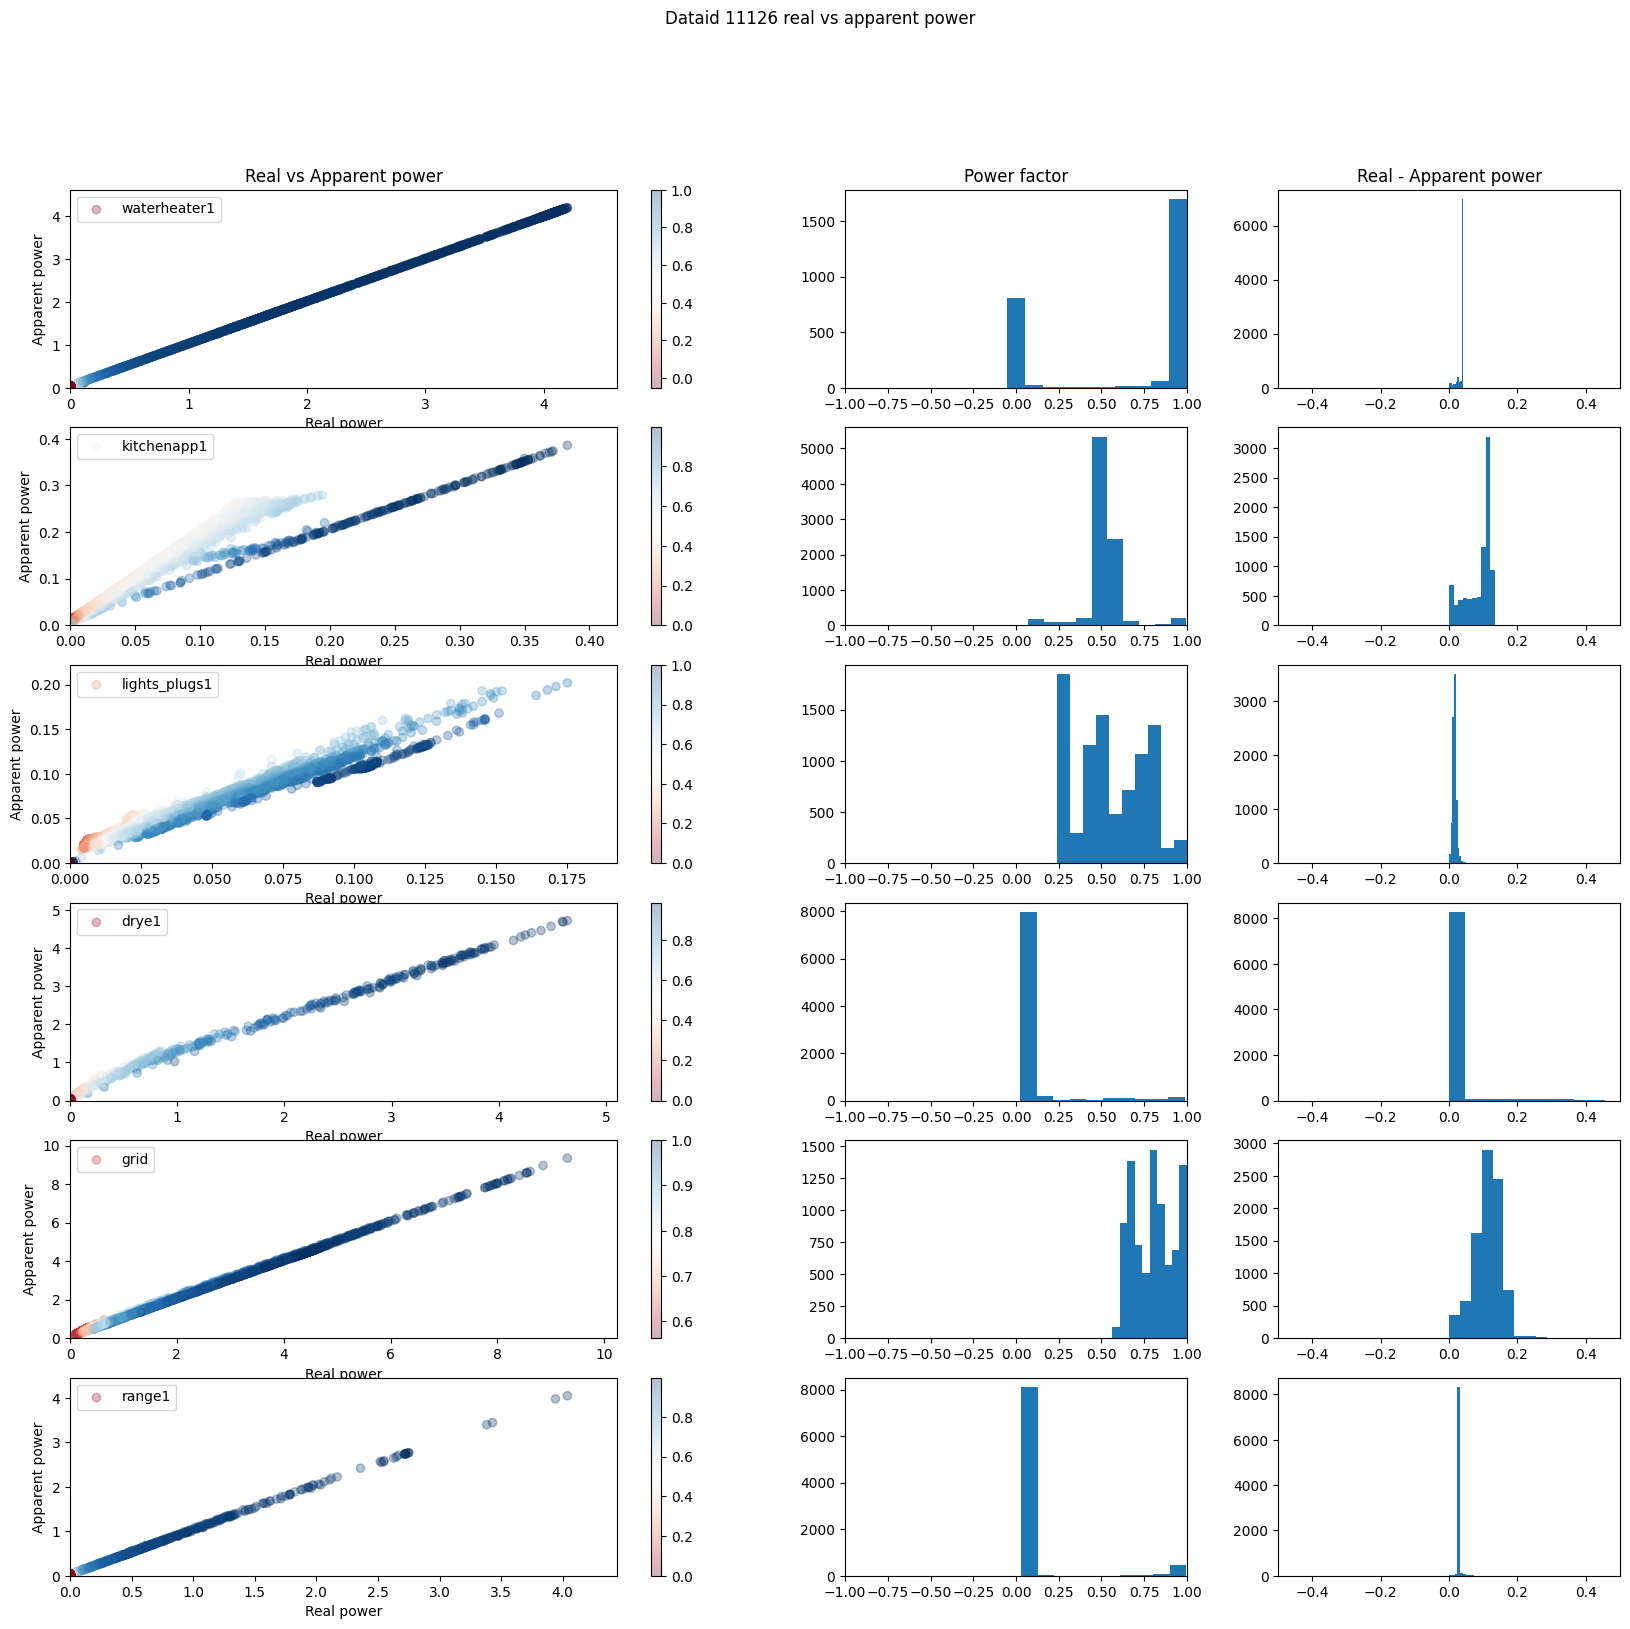

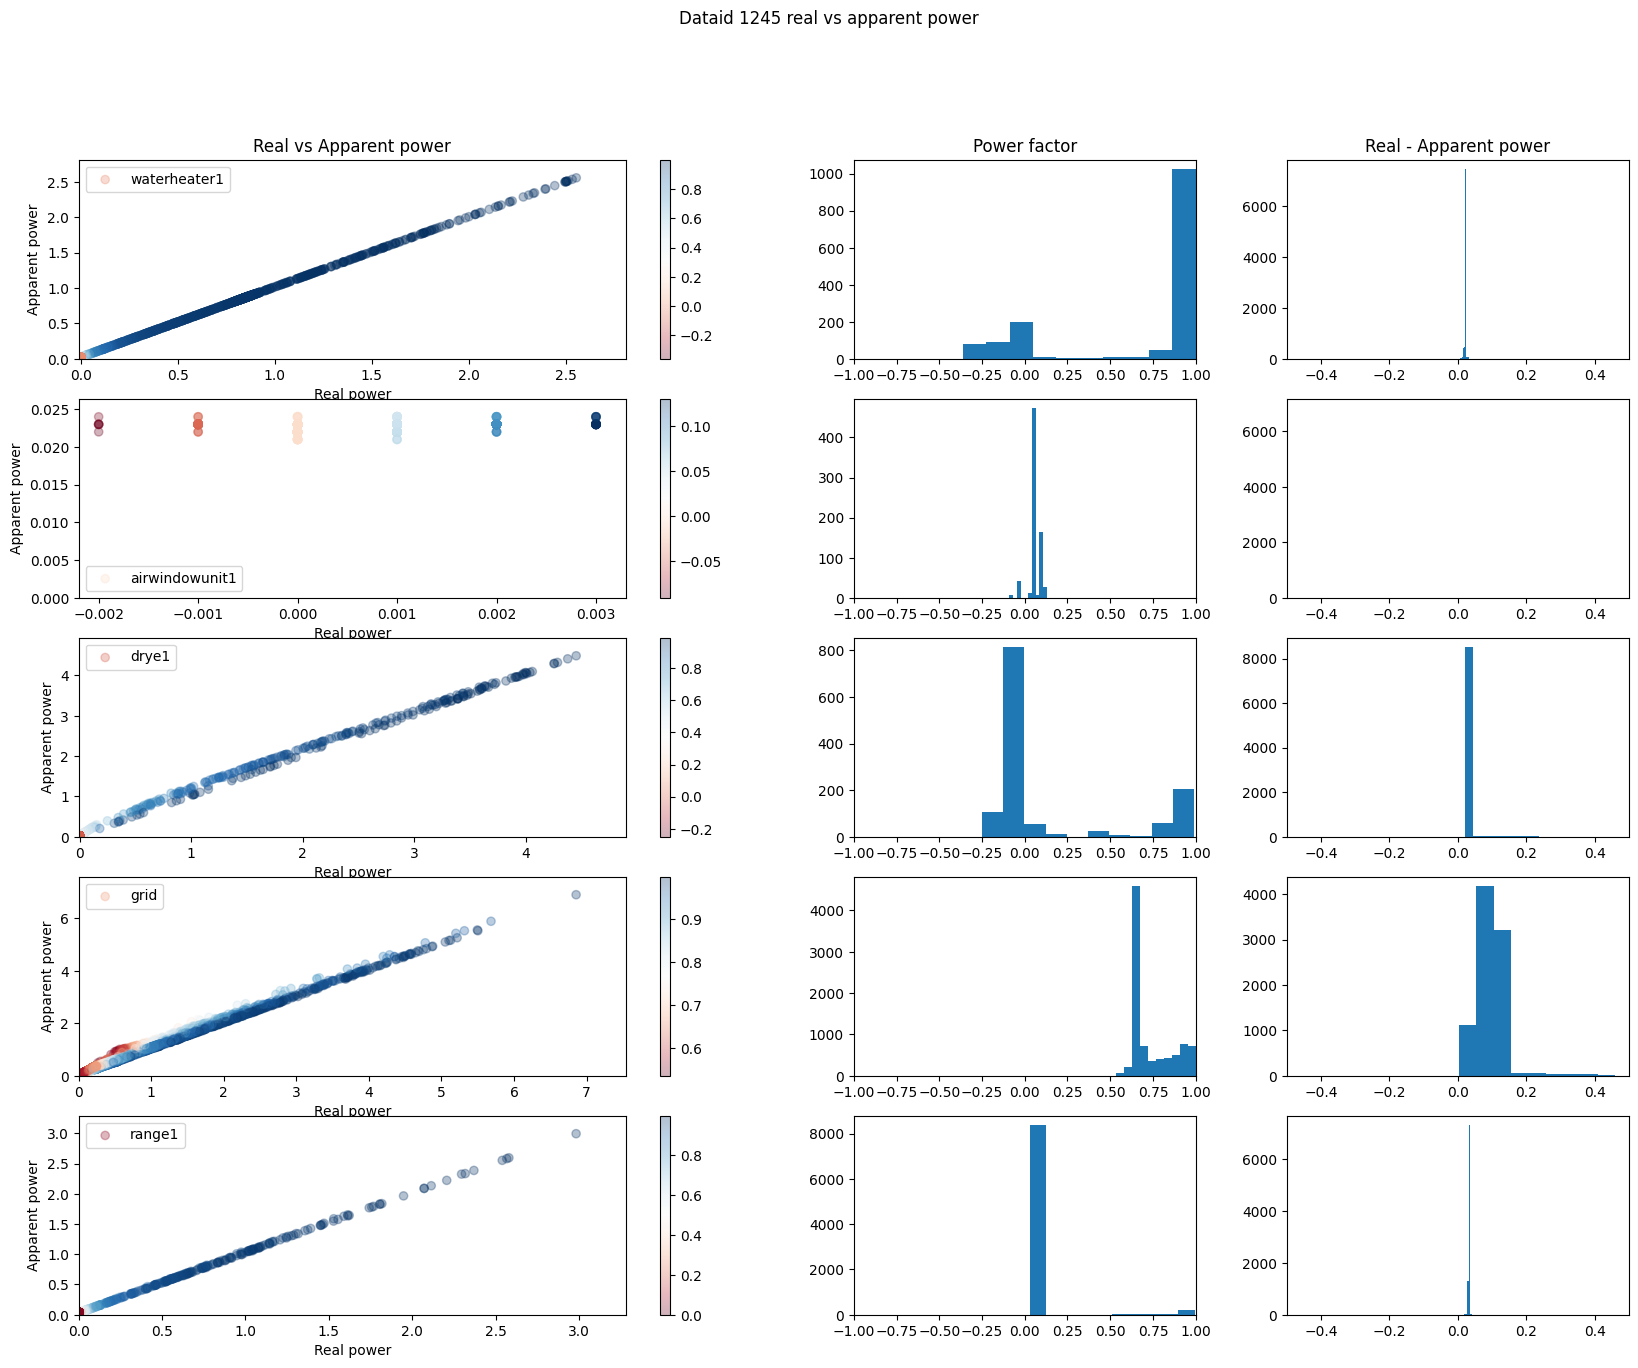

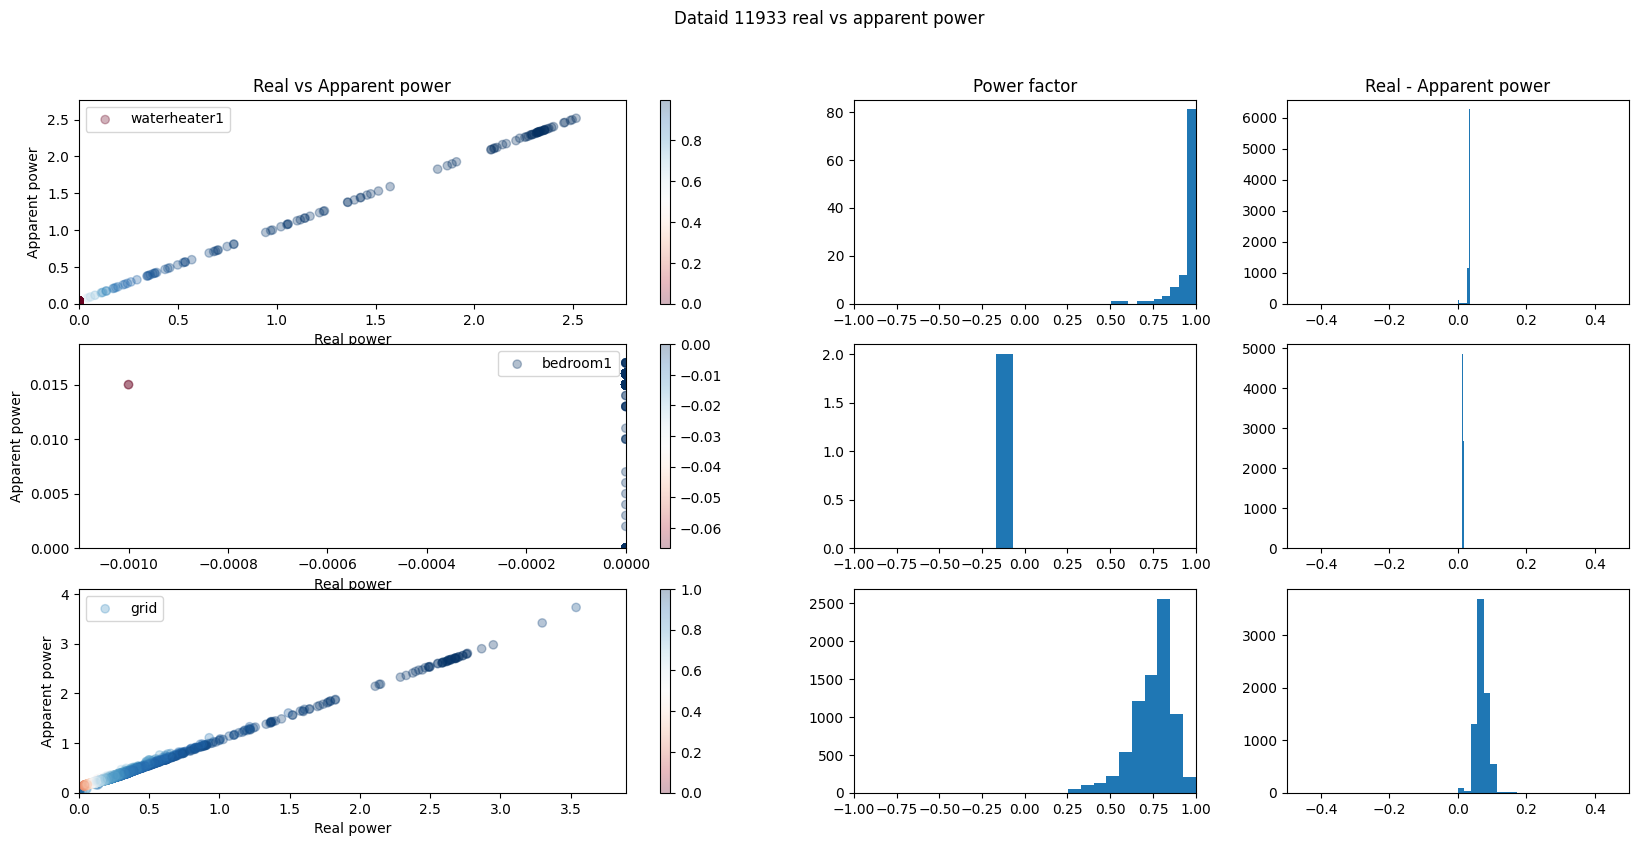

In [18]:
# real power / apparent power comparison
for dataid in dataids__intersect:
    real = (
        dataframes['realpower']
        .query(f'dataid == {dataid}')
        .pipe(drop_100_na)
        .sort_values('local_15min', ascending=True)
        .reset_index(drop=True)
        .drop(columns=['dataid', 'leg1v', 'leg2v'], errors='ignore')

    )

    apparent = (
        dataframes['apparentpower']
        .query(f'dataid == {dataid}')
        .pipe(drop_100_na)
        .sort_values('local_15min', ascending=True)
        .reset_index(drop=True)
        .drop(columns=['dataid', 'leg1v', 'leg2v'], errors='ignore')
    )

    df = (
        real
        .merge(apparent, on='local_15min', suffixes=('#real', '#apparent'))
        .set_index('local_15min')
        .dropna()
    )

    cols = set([col.split('#')[0] for col in df.columns])
    ncols = len(cols)
    fig, ax = plt.subplots(ncols, 3, figsize=(20, 3 * ncols), gridspec_kw={'width_ratios': [2, 1, 1]})
    fig.suptitle(f'Dataid {dataid} real vs apparent power')

    for i, col in enumerate(cols):
        if i == 0:
            ax[i][0].set_title('Real vs Apparent power')
            ax[i][1].set_title('Power factor')
            ax[i][2].set_title('Real - Apparent power')

        try:
            _PF = np.where(df[f'{col}#apparent'] == 0, 0, df[f'{col}#real'] / df[f'{col}#apparent'])
            _DIFF = df[f'{col}#apparent'] - df[f'{col}#real']
            
            sc = ax[i][0].scatter(df[f'{col}#real'], df[f'{col}#apparent'], c=_PF, alpha=0.3, cmap='RdBu', label=col)
            ax[i][0].set_xlabel('Real power')
            ax[i][0].set_ylabel('Apparent power')
            ax[i][0].set_xlim(min(0, df[f'{col}#real'].min()) * 1.1, df[f'{col}#real'].max() * 1.1)
            ax[i][0].set_ylim(min(0, df[f'{col}#apparent'].min()) * 1.1, df[f'{col}#apparent'].max() * 1.1)
            ax[i][0].legend()
            
            
            fig.colorbar(sc, orientation='vertical', ax=ax[i][0])

            _PF = _PF[_PF != 0]

            ax[i][1].hist(_PF)
            ax[i][1].set_xlim(-1, 1)

            ax[i][2].hist(_DIFF)
            ax[i][2].set_xlim(-0.5, 0.5)
        
        except Exception as e:
            print(e)
            continue

    plt.show()

In [19]:
print(dataframes['realpower'].query('dataid == 371').pipe(drop_100_na).columns)
print(dataframes['apparentpower'].query('dataid == 371').pipe(drop_100_na).columns)

# 'lights_plugs2', 'lights_plugs3 are missing from apparent power

Index(['dataid', 'local_15min', 'bedroom1', 'grid', 'kitchen1',
       'lights_plugs1', 'lights_plugs2', 'lights_plugs3', 'refrigerator1',
       'leg1v', 'leg2v'],
      dtype='object')
Index(['dataid', 'local_15min', 'bedroom1', 'grid', 'kitchen1',
       'lights_plugs1', 'refrigerator1'],
      dtype='object')


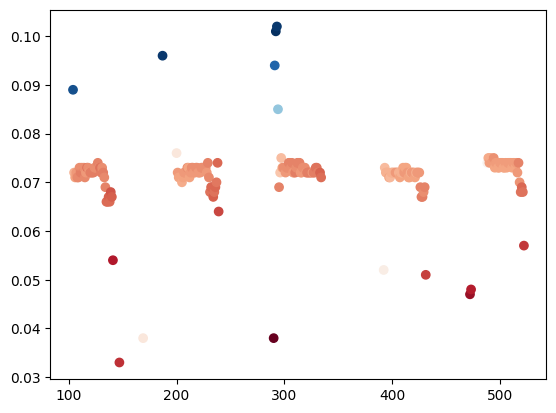

In [71]:
# different appliances at different power factors?

dataid = '2159'
col = 'lights_plugs2'

real = (
    dataframes['realpower']
    .query(f'dataid == {dataid}')
    .pipe(drop_100_na)
    .sort_values('local_15min', ascending=True)
    
    .reset_index(drop=True)
    [[col, 'local_15min']]
    # .drop(columns=['dataid', 'leg1v', 'leg2v'], errors='ignore')

)

apparent = (
    dataframes['apparentpower']
    .query(f'dataid == {dataid}')
    .pipe(drop_100_na)
    .sort_values('local_15min', ascending=True)
    .reset_index(drop=True)
    [[col, 'local_15min']]
    # .drop(columns=['dataid', 'leg1v', 'leg2v'], errors='ignore')
)

df = (
    real
    .merge(apparent, on='local_15min', suffixes=('#real', '#apparent'))
    .set_index('local_15min')
    .dropna()
    .assign(
        pf = lambda x: np.where(x[f'{col}#apparent'] == 0, 0, x[f'{col}#real'] / x[f'{col}#apparent']),
    )
)

_df = df[:int(24*4 * 7 * 1)].reset_index(drop=True).fillna(0).pipe(lambda x: x[x[f'{col}#apparent'] > 0.03])

plt.scatter(_df.index, _df[f'{col}#apparent'], c=_df['pf'].values, cmap='RdBu')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


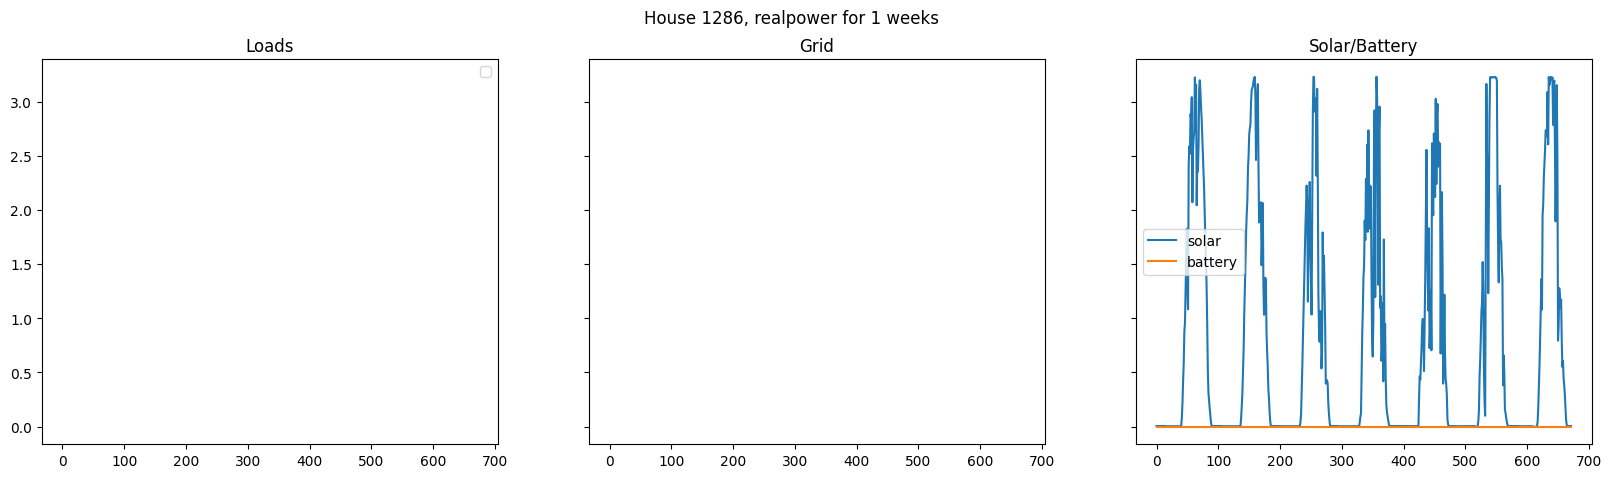

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


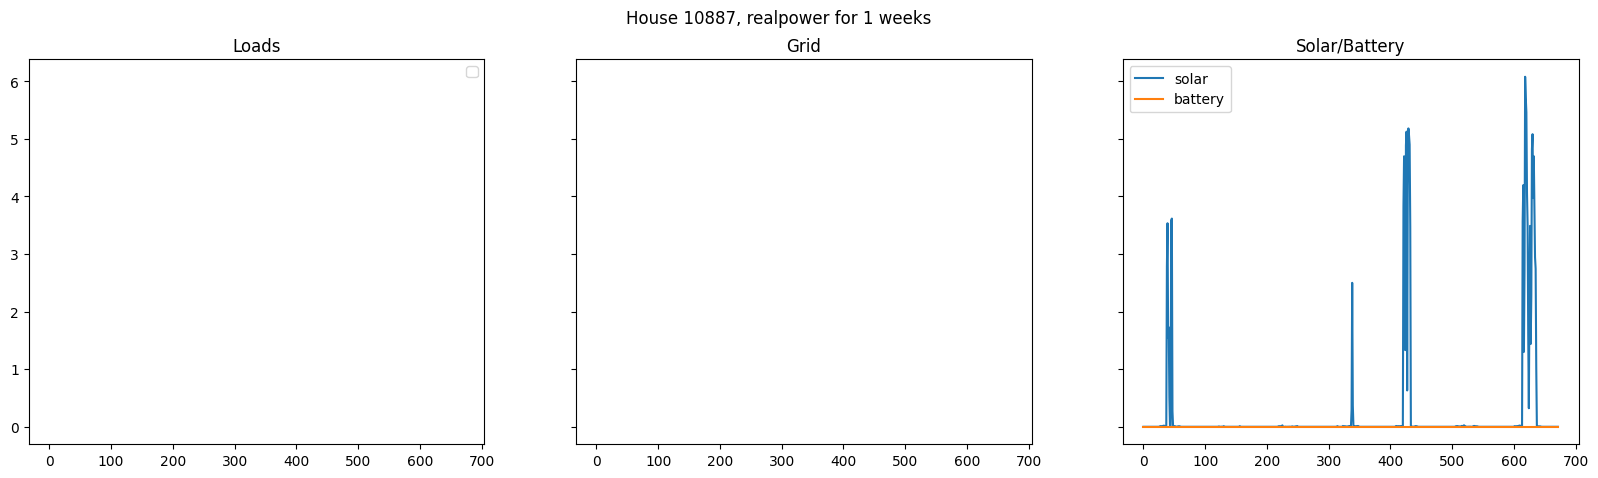

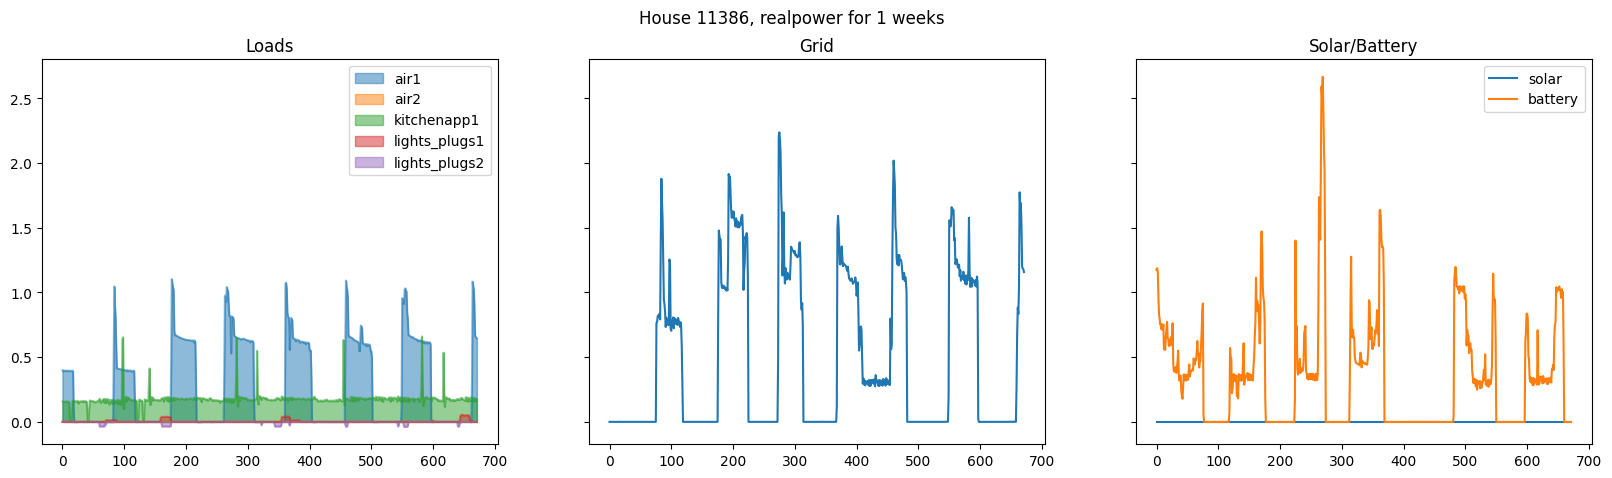

[1286, 10887, 11386]

In [54]:
plot_houses_with_solar(dataframes, 'realpower', 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


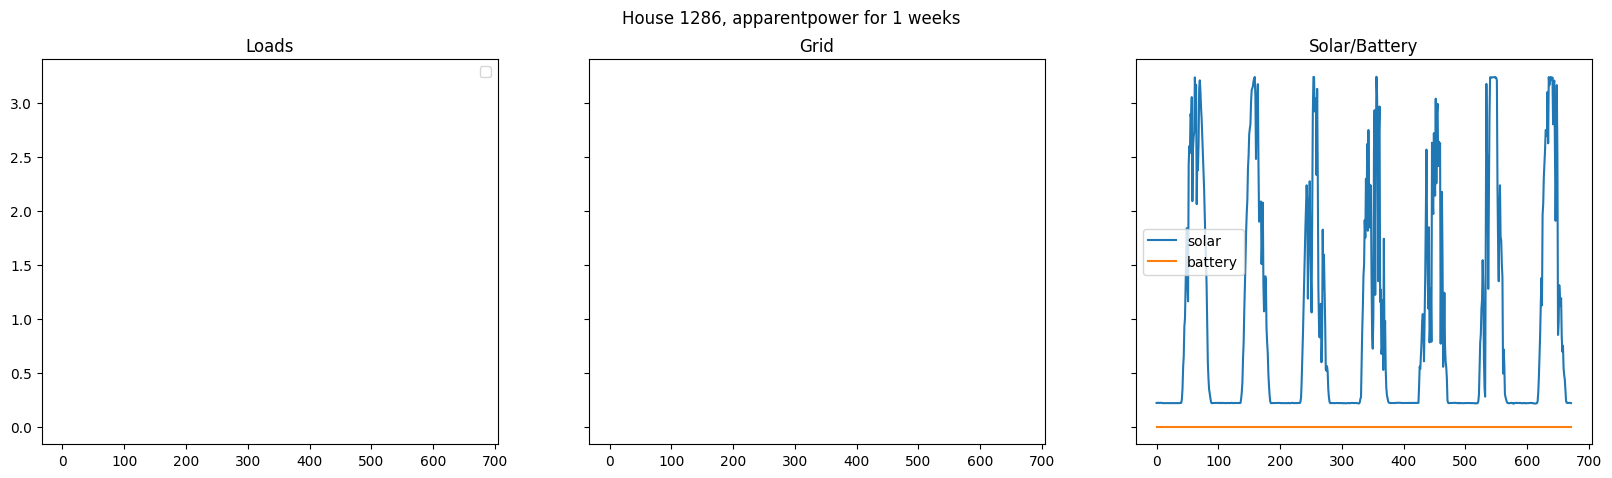

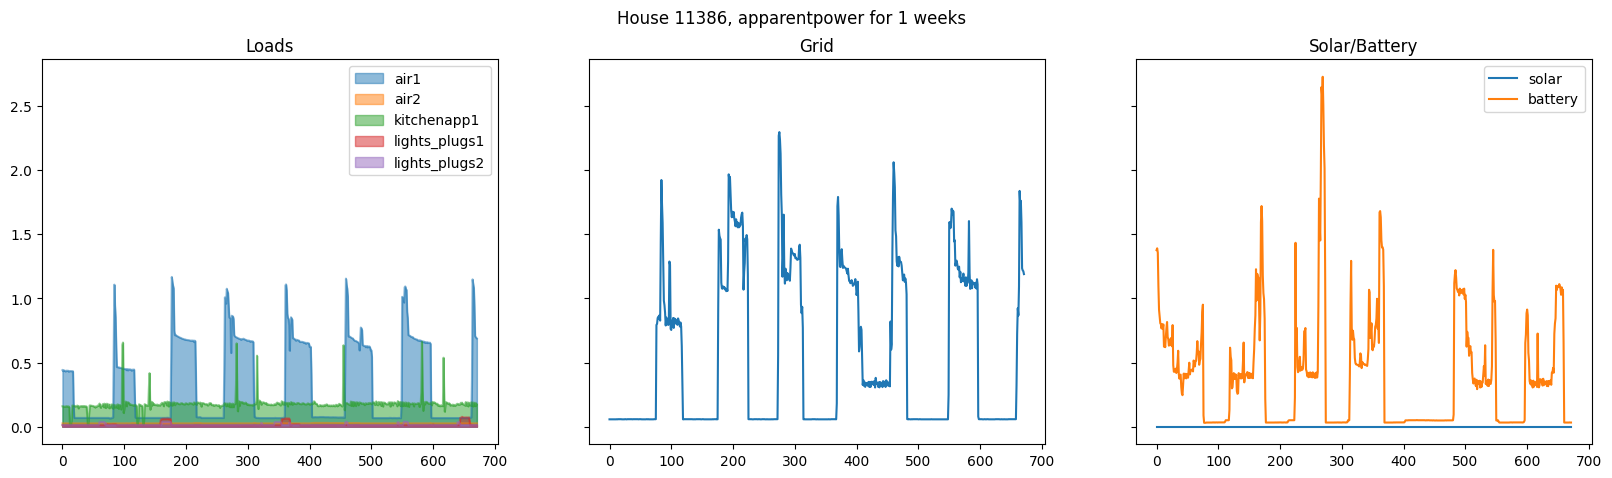

[1286, 11386]

In [55]:
plot_houses_with_solar(dataframes, 'apparentpower', 1)

In [ ]:
# looking into solar
